# Allgemine Analyse

*Kai, Andrew und Fabian*

---

## 1. Bestimmung der Integrationsordnung

- Augmented Dickey-Fuller Test (ADF-Test)
- Phillips-Perron Test (PP-Test)
- Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS-Test)


## 2. Transformation zur Stationarität

- Differenzierung
- Erste Differenz: $y_t - y_{t-1}$
- Zweite Differenz: $(y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$
- Logarithmische Transformation
- Moving Average
- Simple Exponential Smoothing
- HP-Filter (Hodrick-Prescott-Filter)


## 3. ACF und PACF Analyse

- Autokorrelationsfunktion (ACF)
- Partielle Autokorrelationsfunktion (PACF)


## 4. Modellspezifikation

- AR-Modelle (Autoregressive)
- MA-Modelle (Moving Average)
- ARMA-Modelle
- ARIMA-Modelle
- Auto-ARIMA-Modell

In [35]:
########################################################
#--------------------- Librarys -----------------------#
########################################################

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from arch.unitroot import ADF, KPSS, PhillipsPerron
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pmdarima.arima import auto_arima
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import os
import warnings

In [25]:
########################################################
#------------------- data Import ----------------------#
########################################################

samsung_data = pd.read_csv(os.path.join("../data", "005930.ks_aktien_daten.csv"))
daimler_data = pd.read_csv(os.path.join("../data", "mbg.de_aktien_daten.csv"))
microsoft_data = pd.read_csv(os.path.join("../data", "msft_aktien_daten.csv"))

---

---

## **1. Bestimmung der Integrationsordnung**

- Augmented Dickey-Fuller Test (ADF-Test)
- Phillips-Perron Test (PP-Test)
- Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS-Test)

In [26]:
########################################################
#-----------------------   1.   -----------------------#
#--------- Bestimmung der Integrationsordnung ---------#
########################################################

def stationaritaets_tests(zeitreihe, zeitreihen_name="Zeitreihe"):
    """
    Führt ADF-, KPSS- und Phillips-Perron-Test für eine Zeitreihe durch,
    alle implementiert mit der arch.unitroot Bibliothek.
    
    Parameter:
    -----------
    zeitreihe : pandas.Series oder array-like
        Die Zeitreihendaten, die auf Stationarität getestet werden sollen
    zeitreihen_name : str, optional
        Name der Zeitreihe für die Übersichtlichkeit der Ausgabe
    
    Rückgabe:
    --------
    dict
        Dictionary mit Testergebnissen mit den Schlüsseln 'adf', 'kpss' und 'pp'
    """
    ergebnisse = {}
    
    # Stellen wir sicher, dass wir mit einer bereinigten Zeitreihe arbeiten (keine NaN-Werte)
    bereinigte_reihe = pd.Series(zeitreihe).dropna()
    
    print(f"\n===== Stationaritätstests für {zeitreihen_name} =====\n")
    
    # ADF-Test mit arch.unitroot
    print("Augmented Dickey-Fuller Test (arch.unitroot):")
    try:
        adf = ADF(bereinigte_reihe)
        adf_ausgabe = pd.Series(
            [adf.stat, adf.pvalue, adf.lags, adf.nobs, 
             adf.critical_values['1%'], adf.critical_values['5%'], adf.critical_values['10%']],
            index=['Test-Statistik', 'p-Wert', 'Verwendete Lags', 'Anzahl der Beobachtungen', 
                   'Kritischer Wert (1%)', 'Kritischer Wert (5%)', 'Kritischer Wert (10%)']
        )
        print(adf_ausgabe)
        if adf.pvalue <= 0.05:
            print("Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.\n")
        else:
            print("Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist nicht-stationär.\n")
        ergebnisse['adf'] = adf
    except Exception as e:
        print(f"Fehler beim ADF-Test: {e}\n")
        ergebnisse['adf'] = None
    
    # KPSS-Test mit arch.unitroot
    print("KPSS-Test (arch.unitroot):")
    try:
        kpss_test = KPSS(bereinigte_reihe)
        kpss_ausgabe = pd.Series(
            [kpss_test.stat, kpss_test.pvalue, kpss_test.lags, kpss_test.nobs, 
             kpss_test.critical_values['10%'], kpss_test.critical_values['5%'], 
             kpss_test.critical_values['2.5%'] if '2.5%' in kpss_test.critical_values else None, 
             kpss_test.critical_values['1%']],
            index=['Test-Statistik', 'p-Wert', 'Verwendete Lags', 'Anzahl der Beobachtungen', 
                   'Kritischer Wert (10%)', 'Kritischer Wert (5%)', 'Kritischer Wert (2.5%)', 
                   'Kritischer Wert (1%)']
        )
        print(kpss_ausgabe)
        if kpss_test.pvalue <= 0.05:
            print("Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht-stationär.\n")
        else:
            print("Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist stationär.\n")
        ergebnisse['kpss'] = kpss_test
    except Exception as e:
        print(f"Fehler beim KPSS-Test: {e}\n")
        ergebnisse['kpss'] = None
    
    # Phillips-Perron-Test mit arch.unitroot
    print("Phillips-Perron-Test (arch.unitroot):")
    try:
        pp = PhillipsPerron(bereinigte_reihe)
        pp_ausgabe = pd.Series(
            [pp.stat, pp.pvalue, pp.lags, pp.nobs, 
             pp.critical_values['1%'], pp.critical_values['5%'], pp.critical_values['10%']],
            index=['Test-Statistik', 'p-Wert', 'Verwendete Lags', 'Anzahl der Beobachtungen', 
                   'Kritischer Wert (1%)', 'Kritischer Wert (5%)', 'Kritischer Wert (10%)']
        )
        print(pp_ausgabe)
        if pp.pvalue <= 0.05:
            print("Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.\n")
        else:
            print("Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist nicht-stationär.\n")
        ergebnisse['pp'] = pp
    except Exception as e:
        print(f"Fehler beim Phillips-Perron-Test: {e}\n")
        ergebnisse['pp'] = None
    
    return ergebnisse


########################################################
#------------ Stationaritätstests anwenden ------------#
########################################################

# Annahme: Die Daten sind bereits geladen
# Stellen wir sicher, dass wir die Spalte "Close" für jeden Datensatz verwenden
samsung_reihe = samsung_data["Close"]
daimler_reihe = daimler_data["Close"]
microsoft_reihe = microsoft_data["Close"]

# Tests für jeden Datensatz durchführen
samsung_ergebnisse = stationaritaets_tests(samsung_reihe, "Samsung")
daimler_ergebnisse = stationaritaets_tests(daimler_reihe, "Daimler")
microsoft_ergebnisse = stationaritaets_tests(microsoft_reihe, "Microsoft")


===== Stationaritätstests für Samsung =====

Augmented Dickey-Fuller Test (arch.unitroot):
Test-Statistik                -0.716291
p-Wert                         0.842485
Verwendete Lags               28.000000
Anzahl der Beobachtungen    6318.000000
Kritischer Wert (1%)          -3.431385
Kritischer Wert (5%)          -2.861998
Kritischer Wert (10%)         -2.567014
dtype: float64
Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist nicht-stationär.

KPSS-Test (arch.unitroot):
Test-Statistik                11.588162
p-Wert                         0.000100
Verwendete Lags               46.000000
Anzahl der Beobachtungen    6347.000000
Kritischer Wert (10%)          0.347500
Kritischer Wert (5%)           0.461400
Kritischer Wert (2.5%)              NaN
Kritischer Wert (1%)           0.742800
dtype: float64
Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht-stationär.

Phillips-Perron-Test (arch.unitroot):
Test-Statistik                -0

---

---

## 2. Transformation zur Stationarität

- Differenzierung
- Erste Differenz: $y_t - y_{t-1}$
- Zweite Differenz: $(y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$
- Logarithmische Transformation
- Moving Average
- Simple Exponential Smoothing
- HP-Filter (Hodrick-Prescott-Filter)

In [27]:
def stationaritaets_transformationen(zeitreihe, name):
    """
    Führt verschiedene Transformationen zur Stationarität auf einer Zeitreihe durch.
    
    Parameter:
    -----------
    zeitreihe : pandas.Series
        Die zu transformierende Zeitreihe
    name : str
        Name der Zeitreihe für die Benennung der Ausgabevariablen
    
    Rückgabe:
    --------
    dict
        Dictionary mit allen transformierten Zeitreihen
    """
    transformiert = {}
    
    # Originale Zeitreihe speichern
    transformiert[f"{name}_original"] = zeitreihe
    
    # 1. Differenzierung
    # Erste Differenz
    transformiert[f"{name}_diff1"] = zeitreihe.diff().dropna()
    
    # Zweite Differenz
    transformiert[f"{name}_diff2"] = transformiert[f"{name}_diff1"].diff().dropna()
    
    # 2. Logarithmische Transformation
    # Prüfen, ob alle Werte > 0 sind für Log-Transformation
    if all(zeitreihe > 0):
        # Log-Transformation
        transformiert[f"{name}_log"] = np.log(zeitreihe)
        
        # 3. Log-Differenz (Wachstumsrate)
        transformiert[f"{name}_log_diff"] = transformiert[f"{name}_log"].diff().dropna()
    else:
        print(f"Log-Transformation für {name} nicht möglich, da negative oder Null-Werte vorhanden sind.")
    
    # 4. Moving Average
    # Wähle eine geeignete Fensterlänge für MA
    window = 20
    transformiert[f"{name}_ma"] = zeitreihe.rolling(window=window).mean().dropna()
    
    # Differenz zum MA
    ma_temp = zeitreihe.rolling(window=window).mean()
    transformiert[f"{name}_ma_diff"] = (zeitreihe - ma_temp).dropna()
    
    # 5. Simple Exponential Smoothing
    # Optimal Alpha durch Optimierung finden
    try:
        optimal_model = SimpleExpSmoothing(zeitreihe).fit(optimized=True)
        ses_optimal = optimal_model.fittedvalues
        transformiert[f"{name}_ses"] = ses_optimal
        transformiert[f"{name}_ses_diff"] = zeitreihe - ses_optimal
    except:
        print(f"SES für {name} konnte nicht berechnet werden.")
    
    # 6. HP-Filter
    # Für tägliche Daten (Aktienkurse)
    lambda_param = 129600
    
    try:
        cycle, trend = hpfilter(zeitreihe, lamb=lambda_param)
        transformiert[f"{name}_hp_trend"] = trend
        transformiert[f"{name}_hp_cycle"] = cycle
    except Exception as e:
        print(f"HP-Filter für {name} konnte nicht angewendet werden: {e}")
    
    return transformiert

# Funktion anwenden auf alle drei Zeitreihen
def alle_zeitreihen_transformieren(samsung_data, daimler_data, microsoft_data):
    # Stellen wir sicher, dass wir mit der Spalte "Close" arbeiten
    samsung_reihe = samsung_data["Close"]
    daimler_reihe = daimler_data["Close"]
    microsoft_reihe = microsoft_data["Close"]
    
    # Transformationen für jede Zeitreihe berechnen
    samsung_trans = stationaritaets_transformationen(samsung_reihe, "samsung")
    daimler_trans = stationaritaets_transformationen(daimler_reihe, "daimler")
    microsoft_trans = stationaritaets_transformationen(microsoft_reihe, "microsoft")
    
    # Alle Transformationen in ein Dictionary zusammenfassen
    alle_transformationen = {
        "samsung": samsung_trans,
        "daimler": daimler_trans,
        "microsoft": microsoft_trans
    }
    
    return alle_transformationen

transformationen = alle_zeitreihen_transformieren(samsung_data, daimler_data, microsoft_data)

/Users/kaihufnagel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [28]:
def teste_vorhandene_transformationen(transformationen):
    """
    Führt Stationaritätstests für bereits transformierte Zeitreihen durch
    
    Parameter:
    -----------
    transformationen : dict
        Dictionary mit transformierten Zeitreihen, wie von alle_zeitreihen_transformieren() zurückgegeben
    """
    # Durchlaufe jede Aktie
    for aktie_name, trans_dict in transformationen.items():
        print(f"\n{'='*50}")
        print(f"TESTS FÜR {aktie_name.upper()}")
        print(f"{'='*50}")
        
        # Durchlaufe jede Transformation dieser Aktie
        for trans_name, zeitreihe in trans_dict.items():
            # Erstelle einen sauberen Anzeigenamen
            display_name = f"{aktie_name} | {trans_name.replace(f'{aktie_name}_', '')}"
            
            print(f"\n{'-'*15} {display_name} {'-'*15}")
            
            # Führe die Stationaritätstests durch
            stationaritaets_tests(zeitreihe, display_name)

teste_vorhandene_transformationen(transformationen)


TESTS FÜR SAMSUNG

--------------- samsung | original ---------------

===== Stationaritätstests für samsung | original =====

Augmented Dickey-Fuller Test (arch.unitroot):
Test-Statistik                -0.716291
p-Wert                         0.842485
Verwendete Lags               28.000000
Anzahl der Beobachtungen    6318.000000
Kritischer Wert (1%)          -3.431385
Kritischer Wert (5%)          -2.861998
Kritischer Wert (10%)         -2.567014
dtype: float64
Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist nicht-stationär.

KPSS-Test (arch.unitroot):
Test-Statistik                11.588162
p-Wert                         0.000100
Verwendete Lags               46.000000
Anzahl der Beobachtungen    6347.000000
Kritischer Wert (10%)          0.347500
Kritischer Wert (5%)           0.461400
Kritischer Wert (2.5%)              NaN
Kritischer Wert (1%)           0.742800
dtype: float64
Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht-

---

## Stationäre Lof Diff Zeitreihen:

#### **Output:**

## **samsung | log_diff**

===== Stationaritätstests für samsung | log_diff =====

##### **Augmented Dickey-Fuller Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


##### **KPSS-Test (arch.unitroot):**

p-Wert                         0.956299

**Schlussfolgerung:** Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist stationär.


##### **Phillips-Perron-Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


---

## **daimler | log_diff**

===== Stationaritätstests für daimler | log_diff =====

##### **Augmented Dickey-Fuller Test (arch.unitroot):**

p-Wert                      1.052025e-27

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


##### **KPSS-Test (arch.unitroot):**

p-Wert                         0.946683

**Schlussfolgerung:** Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist stationär.


##### **Phillips-Perron-Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


---

### **microsoft | log_diff**

===== Stationaritätstests für microsoft | log_diff =====

##### **Augmented Dickey-Fuller Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


##### **KPSS-Test (arch.unitroot):**

p-Wert                         0.043272

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht-stationär.


##### **Phillips-Perron-Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.

---

---

## 3. ACF und PACF Analyse

- Autokorrelationsfunktion (ACF)
- Partielle Autokorrelationsfunktion (PACF)

In [29]:
def acf_pacf_werte(transformationen, transformation_typ="log_diff"):
    """
    Berechnet ACF und PACF Werte für eine bestimmte Transformation aller Zeitreihen.
    
    Parameter:
    -----------
    transformationen : dict
        Dictionary mit transformierten Zeitreihen
    transformation_typ : str
        Typ der Transformation zu analysieren
    """
    
    ergebnisse = {}
    
    # Durchlaufe jede Aktie
    for aktie_name in ['samsung', 'daimler', 'microsoft']:
        if aktie_name in transformationen:
            trans_key = f"{aktie_name}_{transformation_typ}"
            
            if trans_key in transformationen[aktie_name]:
                zeitreihe = transformationen[aktie_name][trans_key]
                
                # Berechne ACF und PACF
                acf_values = acf(zeitreihe, nlags=40, fft=False)
                pacf_values = pacf(zeitreihe, nlags=40, method='ols')
                
                ergebnisse[aktie_name] = {
                    'acf': acf_values,
                    'pacf': pacf_values
                }
                
                print(f"\n{aktie_name.upper()} - {transformation_typ}")
                print("ACF:", [f"{val:.4f}" for val in acf_values[:10]])
                print("PACF:", [f"{val:.4f}" for val in pacf_values[:10]])
                
                # Bewertung der Stationarität basierend auf ACF/PACF
                # ACF sollte schnell gegen 0 gehen für stationäre Zeitreihen
                acf_schnell_abfallend = all(abs(val) < 0.1 for val in acf_values[5:10])
                
                # Signifikante PACF Lags finden (für ARIMA Parameter)
                pacf_signifikant = [i for i, val in enumerate(pacf_values[1:6], 1) if abs(val) > 0.1]
                acf_signifikant = [i for i, val in enumerate(acf_values[1:6], 1) if abs(val) > 0.1]
                
                # Bewertung ausgeben
                if acf_schnell_abfallend:
                    print("✓ ACF fällt schnell ab - Zeitreihe scheint stationär")
                else:
                    print("✗ ACF fällt langsam ab - möglicherweise nicht vollständig stationär")
                
                if pacf_signifikant:
                    print(f"→ Vorgeschlagenes p (AR-Parameter): {max(pacf_signifikant)}")
                else:
                    print("→ Kein klares p (AR-Parameter) erkennbar")
                
                if acf_signifikant:
                    print(f"→ Vorgeschlagenes q (MA-Parameter): {max(acf_signifikant)}")
                else:
                    print("→ Kein klares q (MA-Parameter) erkennbar")
    
    return ergebnisse

acf_pacf_werte(transformationen, "log_diff")


SAMSUNG - log_diff
ACF: ['1.0000', '0.0396', '-0.0625', '-0.0426', '-0.0421', '-0.0100', '0.0028', '-0.0025', '-0.0046', '-0.0018']
PACF: ['1.0000', '0.0396', '-0.0642', '-0.0376', '-0.0432', '-0.0117', '-0.0034', '-0.0073', '-0.0071', '-0.0030']
✓ ACF fällt schnell ab - Zeitreihe scheint stationär
→ Kein klares p (AR-Parameter) erkennbar
→ Kein klares q (MA-Parameter) erkennbar

DAIMLER - log_diff
ACF: ['1.0000', '0.0351', '-0.0047', '-0.0167', '0.0207', '-0.0264', '-0.0418', '0.0251', '0.0060', '-0.0095']
PACF: ['1.0000', '0.0351', '-0.0060', '-0.0163', '0.0219', '-0.0282', '-0.0401', '0.0286', '0.0023', '-0.0100']
✓ ACF fällt schnell ab - Zeitreihe scheint stationär
→ Kein klares p (AR-Parameter) erkennbar
→ Kein klares q (MA-Parameter) erkennbar

MICROSOFT - log_diff
ACF: ['1.0000', '-0.0176', '-0.0384', '-0.0285', '-0.0235', '0.0104', '-0.0031', '0.0112', '-0.0117', '0.0182']
PACF: ['1.0000', '-0.0176', '-0.0387', '-0.0300', '-0.0262', '0.0072', '-0.0056', '0.0103', '-0.0117', '0

{'samsung': {'acf': array([ 1.        ,  0.03961741, -0.06246157, -0.04259913, -0.04209461,
         -0.00998218,  0.00277057, -0.00252515, -0.0046237 , -0.00176353,
         -0.01022026,  0.00882318, -0.00562351, -0.01283562, -0.00294778,
         -0.00632496,  0.01162141,  0.01339745,  0.03073378,  0.03717625,
         -0.02375663, -0.01085997, -0.02276112,  0.0038908 ,  0.02545009,
         -0.01269233,  0.00596305,  0.01175447, -0.00149705,  0.02235109,
          0.03727539,  0.00634279, -0.03352487,  0.00454714, -0.0254239 ,
          0.01053475,  0.0093392 ,  0.01408287, -0.03186915, -0.0122001 ,
          0.01890005]),
  'pacf': array([ 1.00000000e+00,  3.96194905e-02, -6.42108919e-02, -3.76081643e-02,
         -4.32290277e-02, -1.17224239e-02, -3.36921794e-03, -7.29863343e-03,
         -7.05117399e-03, -2.99735467e-03, -1.13388086e-02,  8.65754214e-03,
         -8.58345932e-03, -1.23774605e-02, -3.26985899e-03, -7.92624246e-03,
          1.02493769e-02,  1.00987660e-02,  3.0334

---

---

## Auto ARIMA


SAMSUNG:
  Bestes Modell: (2, 0, 1)


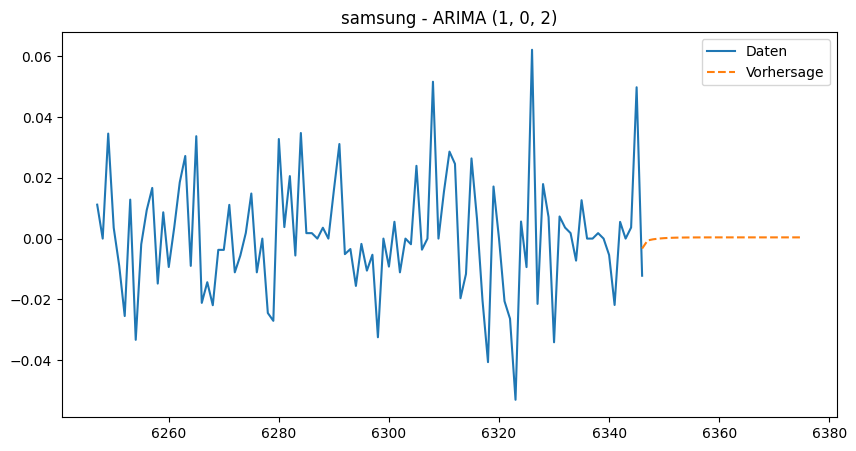


DAIMLER:
  Bestes Modell: (0, 0, 1)


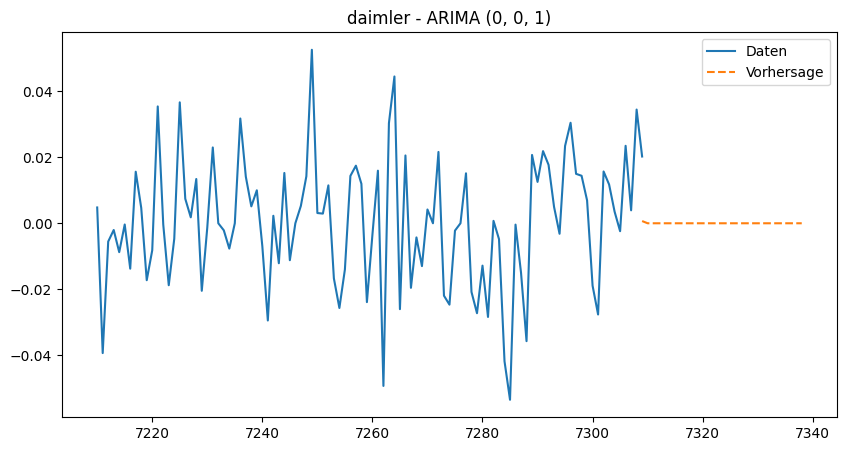


MICROSOFT:
  Bestes Modell: (2, 0, 2)


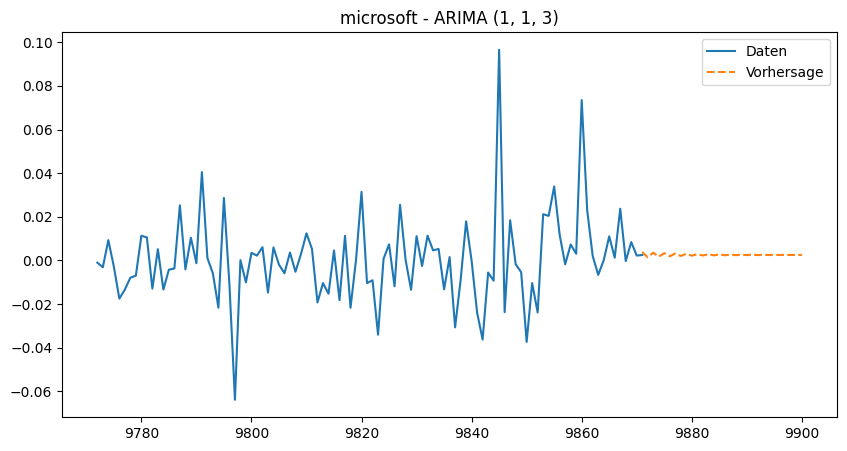

In [36]:
warnings.filterwarnings('ignore')
def auto_arima_simple(transformationen, transformation_typ="log_diff"):
    """
    Erstellt Auto-ARIMA Modelle für alle Zeitreihen mit Expanding Window.
    """
    ergebnisse = {}
    
    for aktie_name in ['samsung', 'daimler', 'microsoft']:
        trans_key = f"{aktie_name}_{transformation_typ}"
        
        if aktie_name in transformationen and trans_key in transformationen[aktie_name]:
            zeitreihe = transformationen[aktie_name][trans_key]
            
            print(f"\n{aktie_name.upper()}:")
            
            # Expanding Window: 40% train, 15% test, dann erweitern
            n = len(zeitreihe)
            train_size = int(0.4 * n)
            test_size = int(0.15 * n)
            
            models = []
            test_errors = []
            
            # Mehrere Windows testen
            for i in range(3):  # 3 Windows
                if train_size + test_size <= n:
                    train_data = zeitreihe.iloc[:train_size]
                    test_data = zeitreihe.iloc[train_size:train_size + test_size]
                    
                    # Auto-ARIMA
                    model = auto_arima(train_data, d=0, max_p=10, max_q=10, 
                                     seasonal=False, suppress_warnings=True)
                    
                    # Test error
                    test_pred = model.predict(n_periods=len(test_data))
                    test_mse = ((test_data - test_pred) ** 2).mean()
                    
                    models.append(model)
                    test_errors.append(test_mse)
                    
                    train_size += test_size
            
            # Bestes Modell
            best_model = models[test_errors.index(min(test_errors))]
            print(f"  Bestes Modell: {best_model.order}")
            
            # Finale Vorhersage auf allen Daten
            final_model = auto_arima(zeitreihe, max_d=10, max_p=10, max_q=10, 
                                   seasonal=False, suppress_warnings=True)
            forecast = final_model.predict(n_periods=30)
            
            # Plot
            plt.figure(figsize=(10, 5))
            plt.plot(zeitreihe.iloc[-100:], label='Daten')
            plt.plot(range(len(zeitreihe), len(zeitreihe) + 30), forecast, 
                    label='Vorhersage', linestyle='--')
            plt.title(f'{aktie_name} - ARIMA {final_model.order}')
            plt.legend()
            plt.show()
            
            ergebnisse[aktie_name] = {
                'model': final_model,
                'forecast': forecast
            }
    
    return ergebnisse

# Verwendung
arima_ergebnisse = auto_arima_simple(transformationen, "log_diff")

## AR & MA Modell Aufbau
---
### Rolling window Methode



Analysiere Zeitreihe: samsung_log_diff
Analyse der Zeitreihe: samsung_log_diff
Warnung: Series hat Namen 'Close', nicht 'Log_Diff'. Verwende 'Close'.

Zeitreiheninformation:
Anzahl der Datenpunkte: 6346

               ROLLING WINDOW ARIMA ANALYSE FÜR samsung_log_diff                

Schritt 1: 40% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 2538 Datenpunkte
Test: 951 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -18317.57
ARIMA(1,0,0) - AIC: -18326.55
ARIMA(1,0,1) - AIC: -18324.55
ARIMA(2,0,0) - AIC: -18328.80
ARIMA(2,0,1) - AIC: -18326.80

Bestes ARIMA-Modell: ARIMA(2, 0, 0)
AIC: -18328.80

Vorhersagegenauigkeit:
MSE: 0.000340
RMSE: 0.018451
MAE: 0.014117


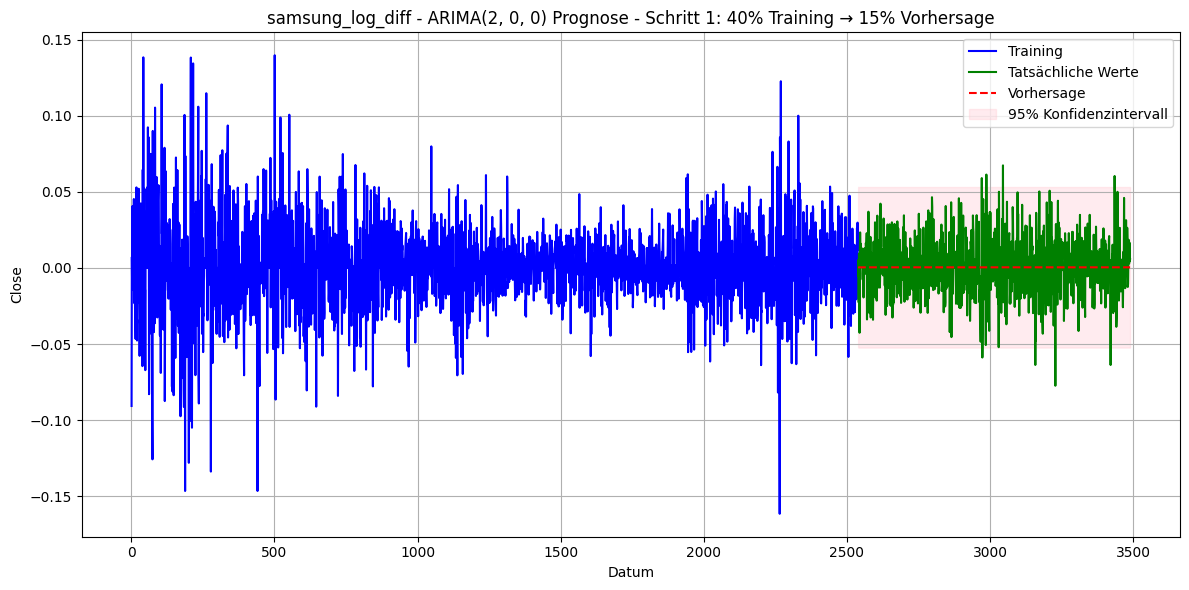


Schritt 2: 55% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 3490 Datenpunkte
Test: 951 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -25741.39
ARIMA(1,0,0) - AIC: -25753.20
ARIMA(1,0,1) - AIC: -25751.20
ARIMA(2,0,0) - AIC: -25761.67
ARIMA(2,0,1) - AIC: -25759.67

Bestes ARIMA-Modell: ARIMA(2, 0, 0)
AIC: -25761.67

Vorhersagegenauigkeit:
MSE: 0.000247
RMSE: 0.015717
MAE: 0.011790


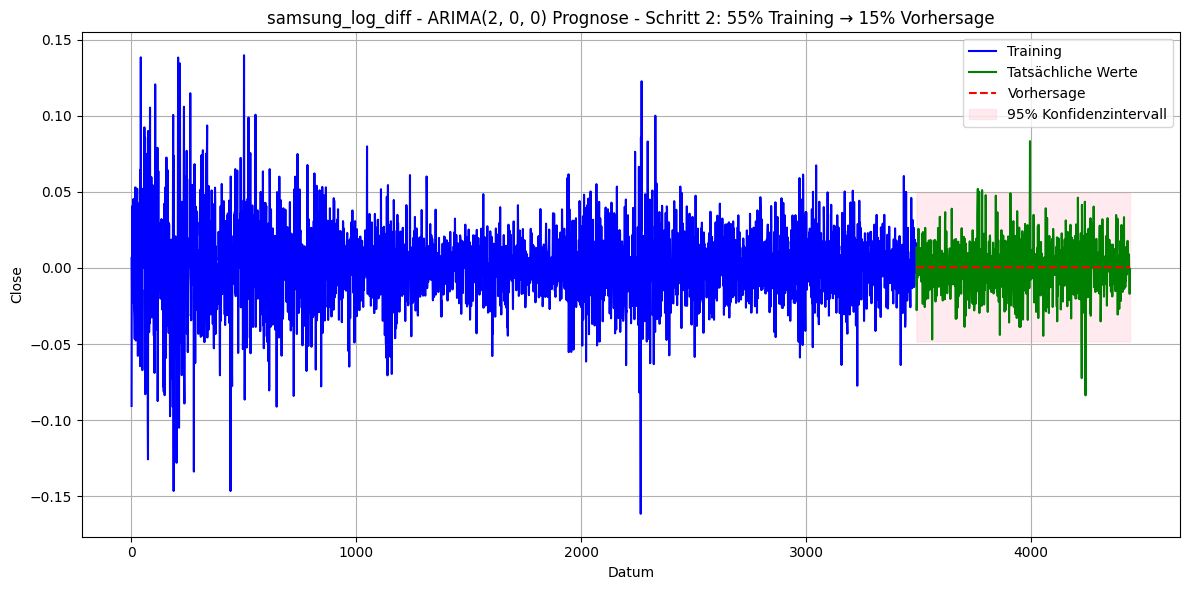


Schritt 3: 70% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 4442 Datenpunkte
Test: 951 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -33378.35
ARIMA(1,0,0) - AIC: -33394.00
ARIMA(1,0,1) - AIC: -33392.00
ARIMA(2,0,0) - AIC: -33409.65
ARIMA(2,0,1) - AIC: -33407.65

Bestes ARIMA-Modell: ARIMA(2, 0, 0)
AIC: -33409.65

Vorhersagegenauigkeit:
MSE: 0.000299
RMSE: 0.017298
MAE: 0.012899


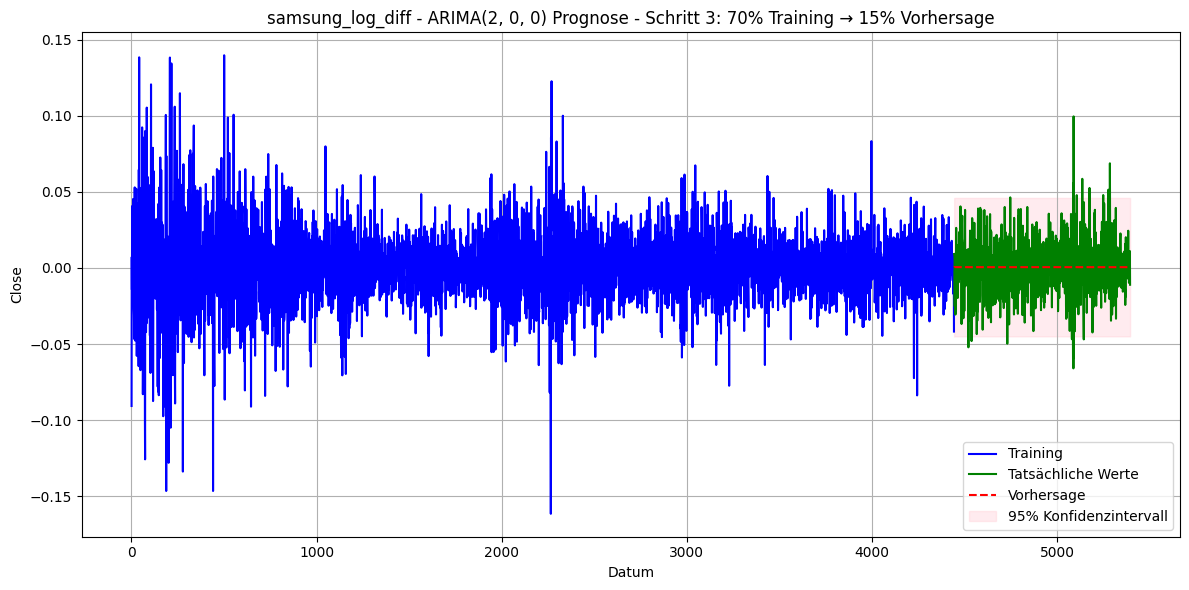


Schritt 4: 85% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 5394 Datenpunkte
Test: 951 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -40980.42
ARIMA(1,0,0) - AIC: -40997.24
ARIMA(1,0,1) - AIC: -40995.24
ARIMA(2,0,0) - AIC: -41008.38
ARIMA(2,0,1) - AIC: -41006.38

Bestes ARIMA-Modell: ARIMA(2, 0, 0)
AIC: -41008.38

Vorhersagegenauigkeit:
MSE: 0.000262
RMSE: 0.016185
MAE: 0.011789


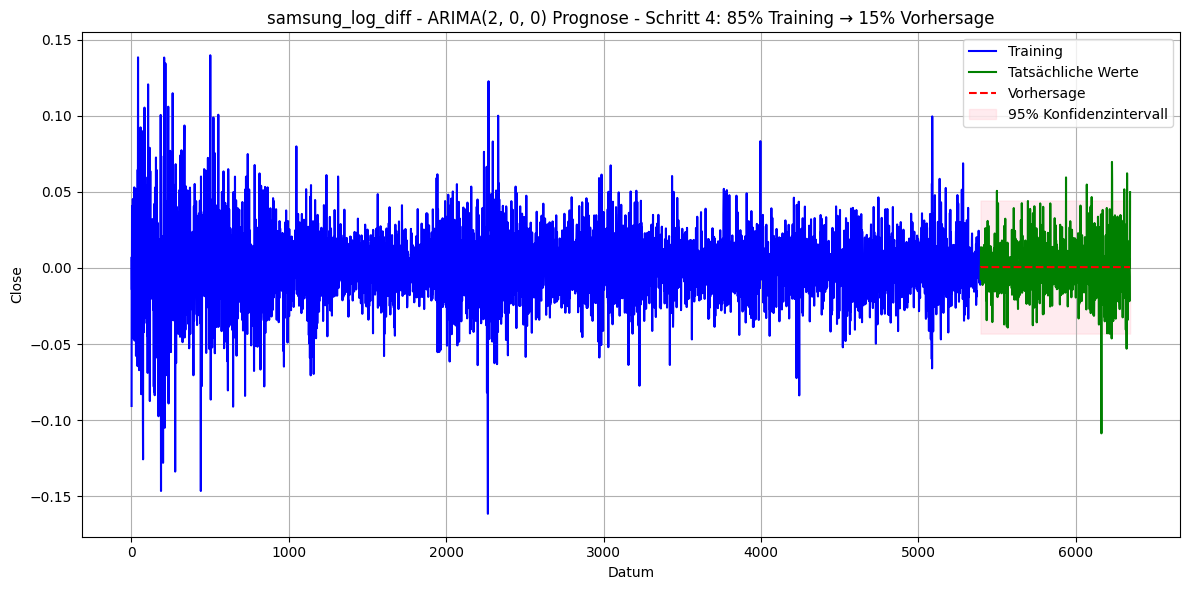


        ZUSAMMENFASSUNG DER ROLLING WINDOW ANALYSE FÜR samsung_log_diff         

ARIMA-Parameter in den verschiedenen Schritten:
Schritt 1: ARIMA(2, 0, 0)
Schritt 2: ARIMA(2, 0, 0)
Schritt 3: ARIMA(2, 0, 0)
Schritt 4: ARIMA(2, 0, 0)

Fehlermetriken:
Schritt    MSE             RMSE            MAE            
-------------------------------------------------------
         1        0.000340        0.018451        0.014117
         2        0.000247        0.015717        0.011790
         3        0.000299        0.017298        0.012899
         4        0.000262        0.016185        0.011789

Lerneffekt des Modells:
Das Modell hat konsistente Parameter über alle Schritte hinweg: ARIMA(2, 0, 0)
Bestes Modell für samsung_log_diff: ARIMA(2, 0, 0) mit RMSE: 0.015717

Analysiere Zeitreihe: daimler_log_diff
Analyse der Zeitreihe: daimler_log_diff
Warnung: Series hat Namen 'Close', nicht 'Log_Diff'. Verwende 'Close'.

Zeitreiheninformation:
Anzahl der Datenpunkte: 7309

               ROL

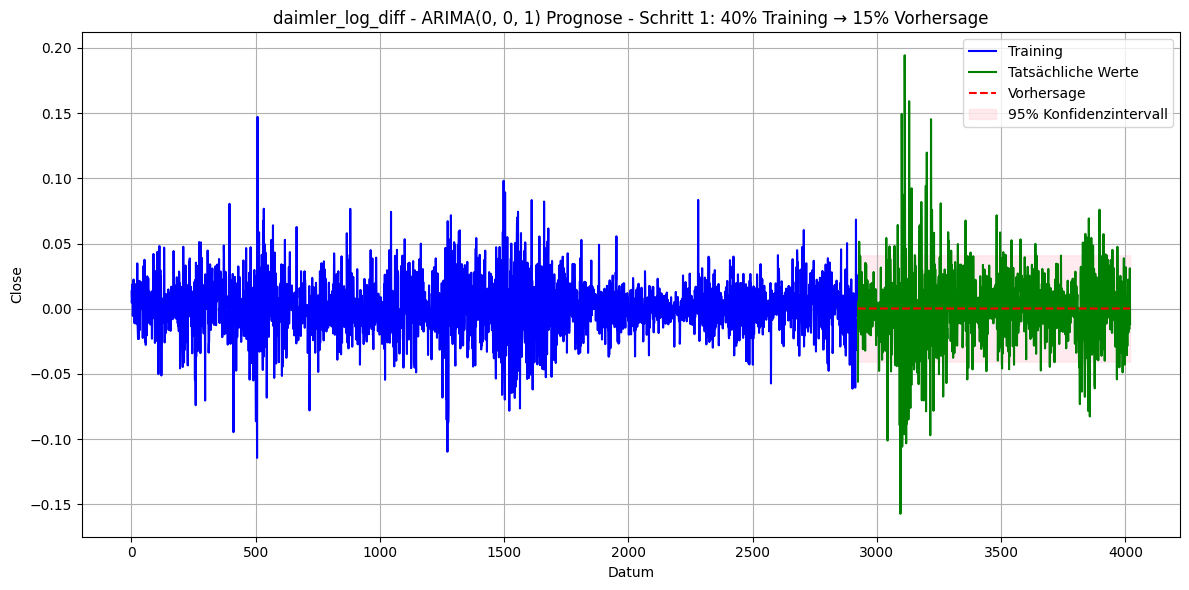


Schritt 2: 55% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 4019 Datenpunkte
Test: 1096 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -30211.09
ARIMA(1,0,0) - AIC: -30208.93
ARIMA(1,0,1) - AIC: -30206.93
ARIMA(2,0,0) - AIC: -30200.06
ARIMA(2,0,1) - AIC: -30198.06

Bestes ARIMA-Modell: ARIMA(0, 0, 1)
AIC: -30211.09

Vorhersagegenauigkeit:
MSE: 0.000290
RMSE: 0.017039
MAE: 0.012899


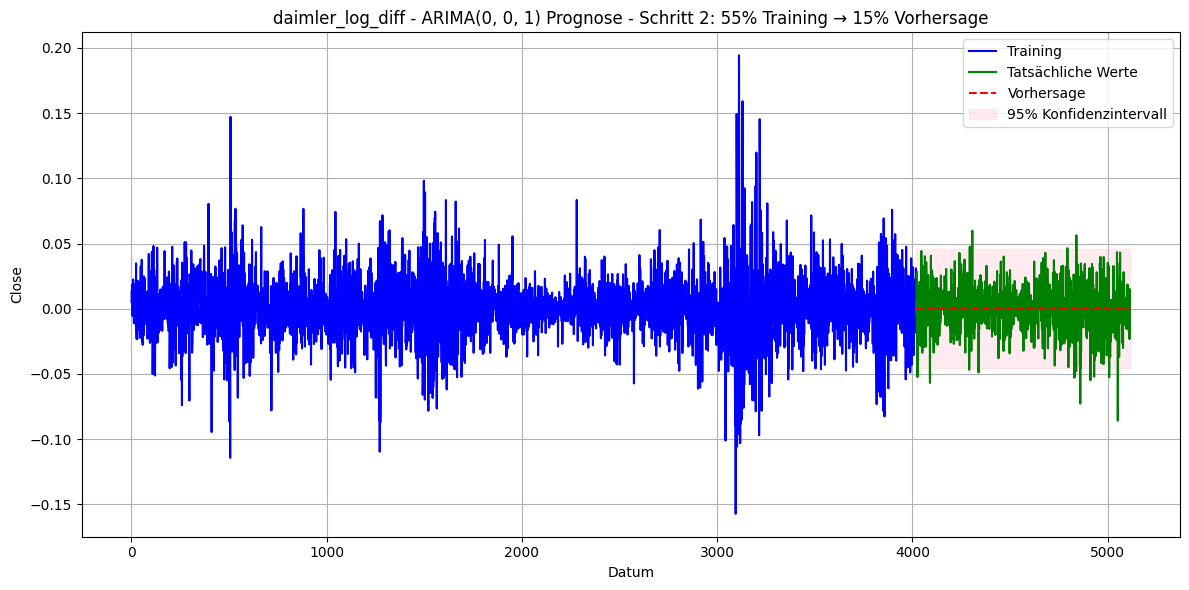


Schritt 3: 70% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 5116 Datenpunkte
Test: 1096 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -38995.40
ARIMA(1,0,0) - AIC: -38995.66
ARIMA(1,0,1) - AIC: -38993.66
ARIMA(2,0,0) - AIC: -38986.73
ARIMA(2,0,1) - AIC: -38984.73

Bestes ARIMA-Modell: ARIMA(1, 0, 0)
AIC: -38995.66

Vorhersagegenauigkeit:
MSE: 0.000449
RMSE: 0.021183
MAE: 0.012633


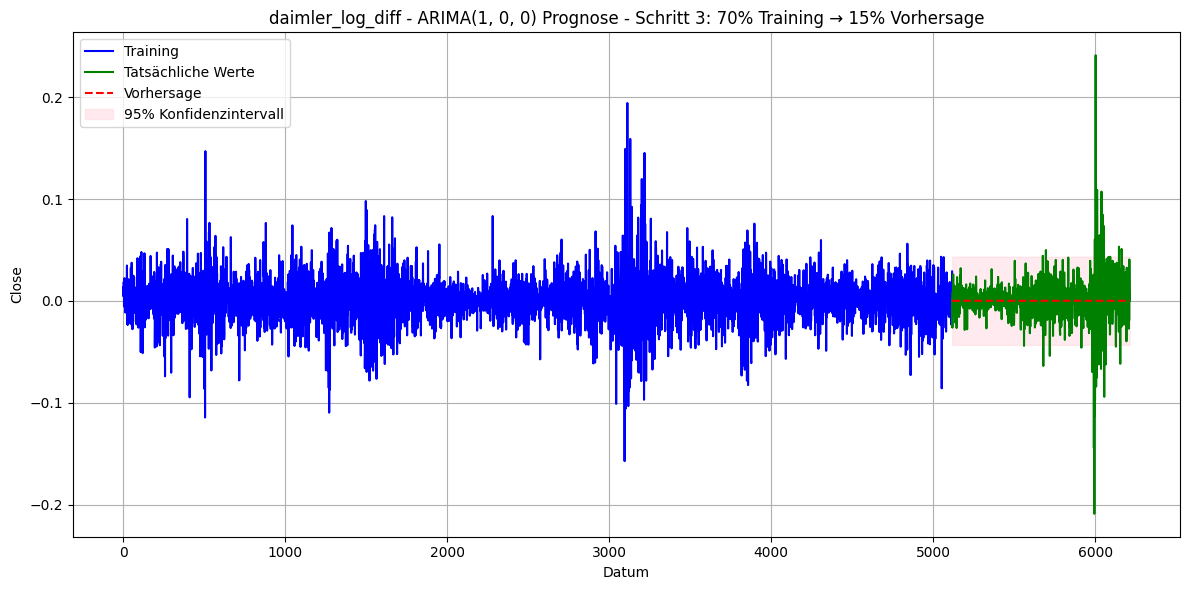


Schritt 4: 85% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 6212 Datenpunkte
Test: 1096 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -47441.35
ARIMA(1,0,0) - AIC: -47440.87
ARIMA(1,0,1) - AIC: -47438.87
ARIMA(2,0,0) - AIC: -47430.41
ARIMA(2,0,1) - AIC: -47428.41

Bestes ARIMA-Modell: ARIMA(0, 0, 1)
AIC: -47441.35

Vorhersagegenauigkeit:
MSE: 0.000314
RMSE: 0.017713
MAE: 0.012687


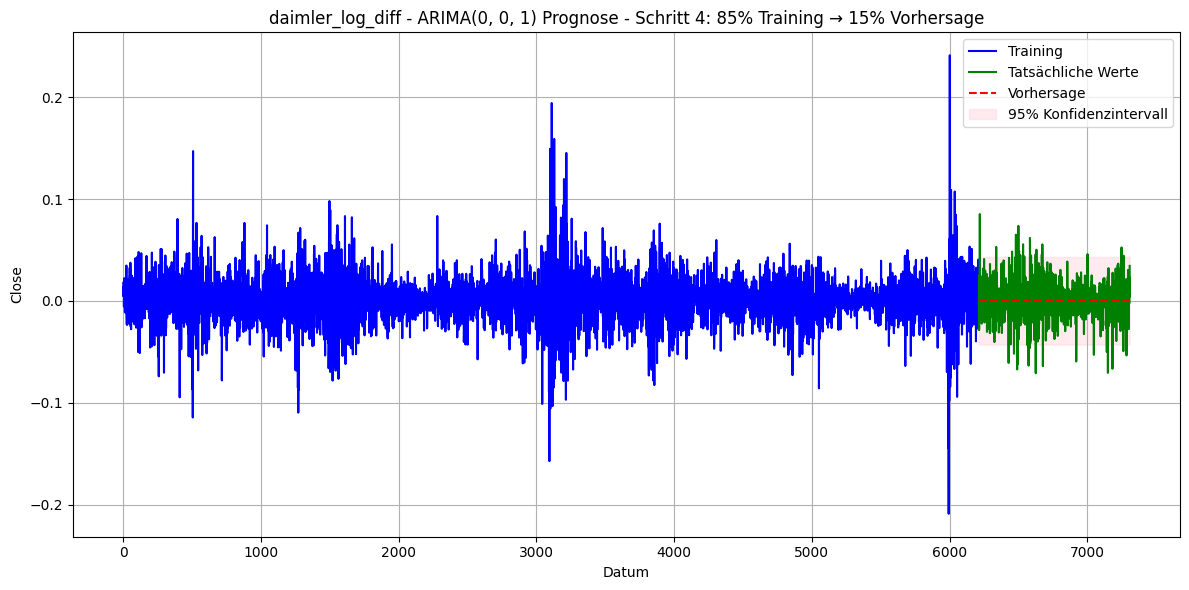


        ZUSAMMENFASSUNG DER ROLLING WINDOW ANALYSE FÜR daimler_log_diff         

ARIMA-Parameter in den verschiedenen Schritten:
Schritt 1: ARIMA(0, 0, 1)
Schritt 2: ARIMA(0, 0, 1)
Schritt 3: ARIMA(1, 0, 0)
Schritt 4: ARIMA(0, 0, 1)

Fehlermetriken:
Schritt    MSE             RMSE            MAE            
-------------------------------------------------------
         1        0.000838        0.028953        0.020388
         2        0.000290        0.017039        0.012899
         3        0.000449        0.021183        0.012633
         4        0.000314        0.017713        0.012687

Lerneffekt des Modells:
Das Modell hat in den verschiedenen Schritten unterschiedliche Parameter gewählt:
Schritt 1: ARIMA(0, 0, 1)
Schritt 2: ARIMA(0, 0, 1)
Schritt 3: ARIMA(1, 0, 0)
Schritt 4: ARIMA(0, 0, 1)
Bestes Modell für daimler_log_diff: ARIMA(0, 0, 1) mit RMSE: 0.017039

Analysiere Zeitreihe: microsoft_log_diff
Analyse der Zeitreihe: microsoft_log_diff
Warnung: Series hat Namen 'Close

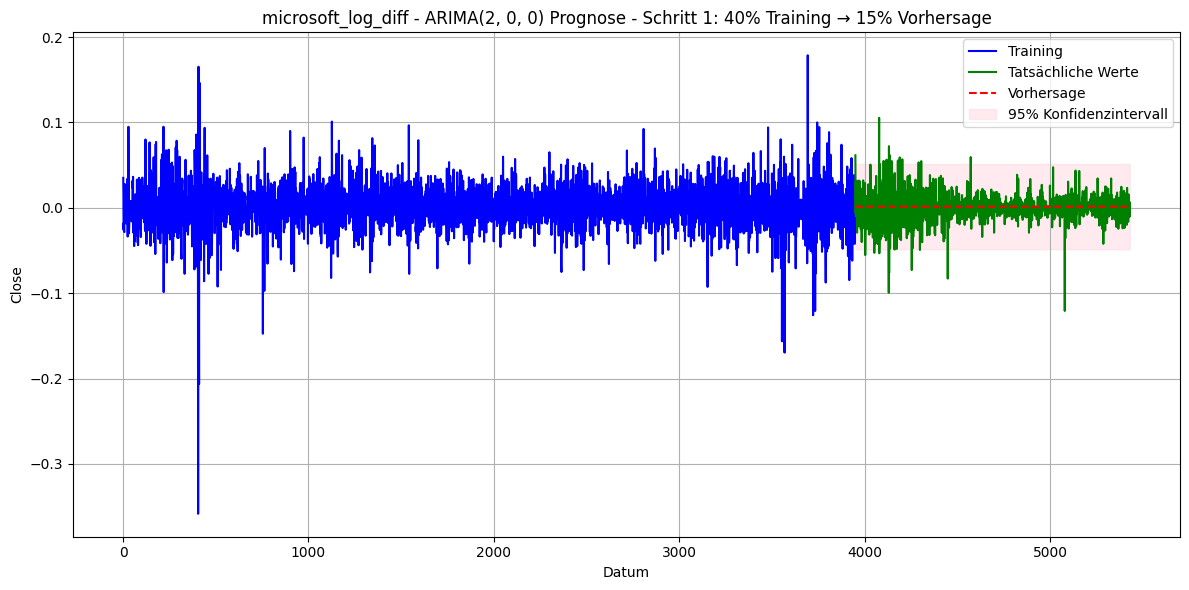


Schritt 2: 55% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 5429 Datenpunkte
Test: 1480 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -40765.83
ARIMA(1,0,0) - AIC: -40762.40
ARIMA(1,0,1) - AIC: -40760.40
ARIMA(2,0,0) - AIC: -40762.22
ARIMA(2,0,1) - AIC: -40760.22

Bestes ARIMA-Modell: ARIMA(0, 0, 1)
AIC: -40765.83

Vorhersagegenauigkeit:
MSE: 0.000393
RMSE: 0.019818
MAE: 0.013393


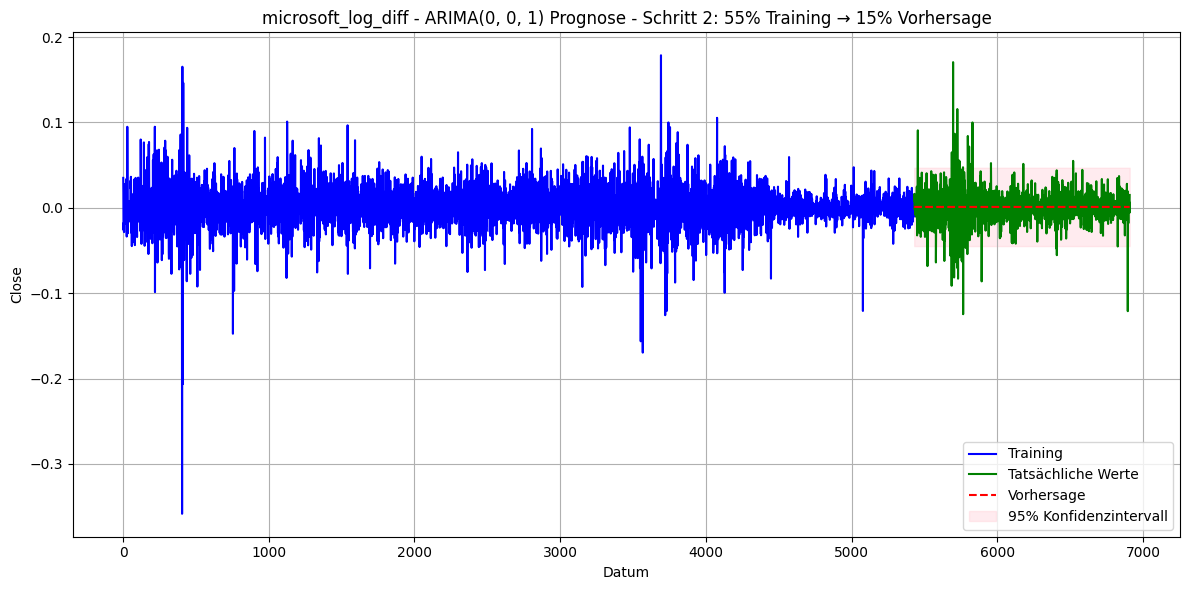


Schritt 3: 70% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 6909 Datenpunkte
Test: 1480 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -52312.72
ARIMA(1,0,0) - AIC: -52306.70
ARIMA(1,0,1) - AIC: -52304.70
ARIMA(2,0,0) - AIC: -52311.01
ARIMA(2,0,1) - AIC: -52309.01

Bestes ARIMA-Modell: ARIMA(0, 0, 1)
AIC: -52312.72

Vorhersagegenauigkeit:
MSE: 0.000213
RMSE: 0.014583
MAE: 0.010018


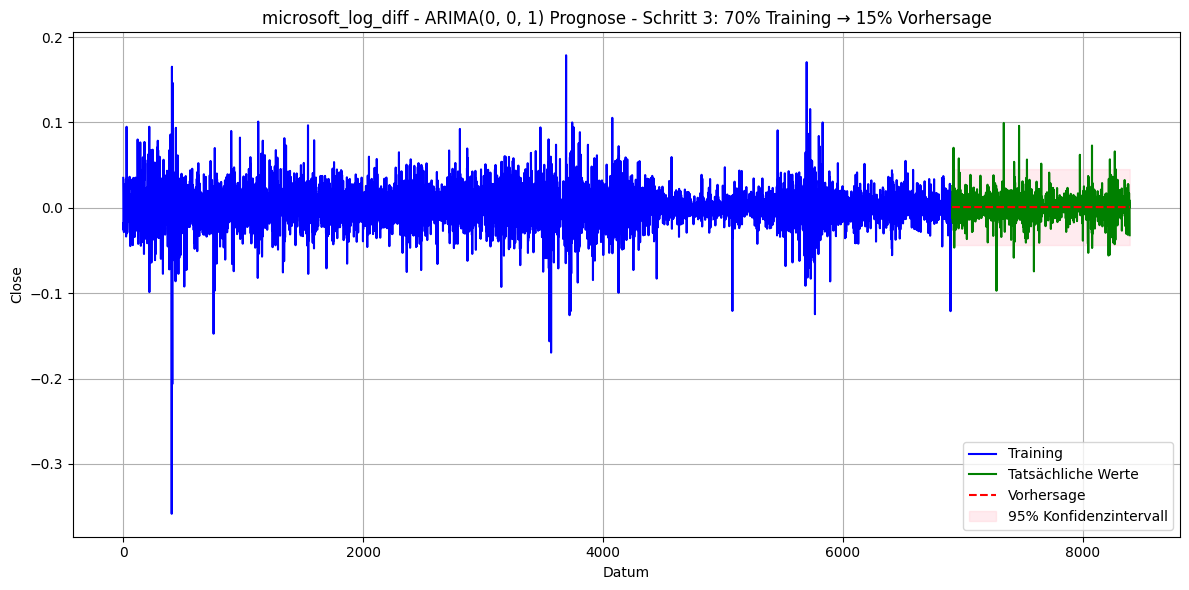


Schritt 4: 85% Training → 15% Vorhersage:
--------------------------------------------------------------------------------
Training: 8390 Datenpunkte
Test: 1480 Datenpunkte

Führe Grid-Suche für ARIMA-Parameter durch...
ARIMA(0,0,1) - AIC: -64444.91
ARIMA(1,0,0) - AIC: -64438.80
ARIMA(1,0,1) - AIC: -64436.80
ARIMA(2,0,0) - AIC: -64447.19
ARIMA(2,0,1) - AIC: -64445.19

Bestes ARIMA-Modell: ARIMA(2, 0, 0)
AIC: -64447.19

Vorhersagegenauigkeit:
MSE: 0.000351
RMSE: 0.018741
MAE: 0.013039


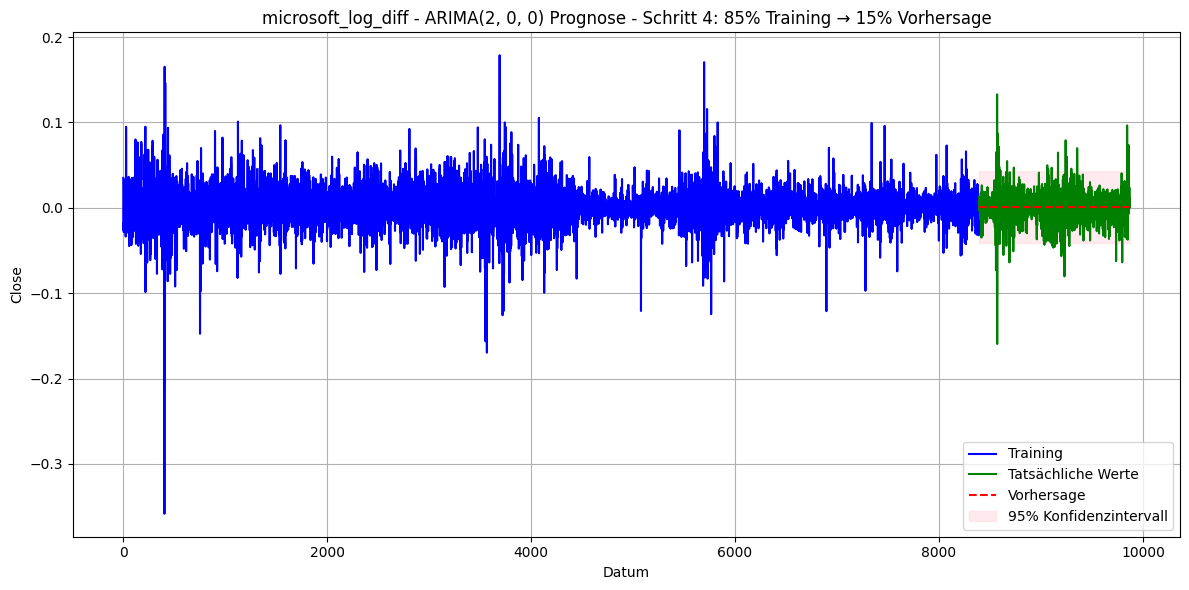


       ZUSAMMENFASSUNG DER ROLLING WINDOW ANALYSE FÜR microsoft_log_diff        

ARIMA-Parameter in den verschiedenen Schritten:
Schritt 1: ARIMA(2, 0, 0)
Schritt 2: ARIMA(0, 0, 1)
Schritt 3: ARIMA(0, 0, 1)
Schritt 4: ARIMA(2, 0, 0)

Fehlermetriken:
Schritt    MSE             RMSE            MAE            
-------------------------------------------------------
         1        0.000273        0.016529        0.011389
         2        0.000393        0.019818        0.013393
         3        0.000213        0.014583        0.010018
         4        0.000351        0.018741        0.013039

Lerneffekt des Modells:
Das Modell hat in den verschiedenen Schritten unterschiedliche Parameter gewählt:
Schritt 1: ARIMA(2, 0, 0)
Schritt 2: ARIMA(0, 0, 1)
Schritt 3: ARIMA(0, 0, 1)
Schritt 4: ARIMA(2, 0, 0)
Bestes Modell für microsoft_log_diff: ARIMA(0, 0, 1) mit RMSE: 0.014583


In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import math

class SimpleARIMA:
    """Eine einfache ARIMA(p,d,q)-Implementierung ohne statsmodels-Abhängigkeiten"""
    
    def __init__(self, p=1, d=0, q=1):
        self.p = p  # AR-Term
        self.d = d  # Differenzierungsgrad
        self.q = q  # MA-Term
        self.ar_coefs = None
        self.ma_coefs = None
        self.intercept = None
        self.resid = None
        self.fitted_values = None
    
    def _create_ar_features(self, y):
        """Erstellt AR-Features für die Regression"""
        n = len(y)
        X = np.zeros((n - self.p, self.p))
        for i in range(self.p):
            X[:, i] = y[self.p - i - 1:n - i - 1]
        return X
    
    def _difference(self, y, d=1):
        """Differenziert die Zeitreihe d-mal"""
        diff_y = y.copy()
        for _ in range(d):
            diff_y = np.diff(diff_y)
        return diff_y
    
    def _integrate(self, diff_y, original_y, d=1):
        """Integriert die differenzierte Zeitreihe zurück"""
        y = diff_y.copy()
        for i in range(d):
            y_prev = original_y[-d + i:][:len(y) + 1]
            y = np.cumsum(y) + y_prev[0]
        return y
    
    def fit(self, y):
        """Fittet das ARIMA-Modell an die Daten"""
        # Schritt 1: Differenzieren
        if self.d > 0:
            self.original_y = y.copy()
            y_diff = self._difference(y, self.d)
        else:
            y_diff = y.copy()
        
        # Schritt 2: AR-Modell fitten
        if self.p > 0:
            # AR-Features erstellen
            X_ar = self._create_ar_features(y_diff)
            y_ar = y_diff[self.p:]
            
            # Regression fitten
            model = LinearRegression()
            model.fit(X_ar, y_ar)
            
            # Koeffizienten speichern
            self.ar_coefs = model.coef_
            self.intercept = model.intercept_
            
            # Fitted values
            self.fitted_values = model.predict(X_ar)
            
            # Residuen berechnen
            self.resid = y_ar - self.fitted_values
        else:
            # Kein AR-Term
            self.intercept = np.mean(y_diff)
            self.ar_coefs = np.array([])
            self.fitted_values = np.repeat(self.intercept, len(y_diff) - self.p)
            self.resid = y_diff[self.p:] - self.fitted_values
        
        # Schritt 3: MA-Modell ist vereinfacht und ignoriert q
        # In einer vollständigen Implementierung würden wir hier auch MA-Terme modellieren
        self.ma_coefs = np.array([])
        
        return self
    
    def predict(self, n_steps):
        """Erstellt Vorhersagen für n_steps zukünftige Zeitpunkte"""
        # Vorbereitungen
        predictions = np.zeros(n_steps)
        
        if self.p > 0:
            # Die letzten p Werte als Ausgangspunkt nehmen
            if self.d > 0:
                y_diff = self._difference(self.original_y, self.d)
                last_values = y_diff[-self.p:]
            else:
                last_values = self.fitted_values[-self.p:]
        
            # Vorhersagen generieren
            for i in range(n_steps):
                # AR-Teil
                ar_pred = self.intercept
                for j in range(self.p):
                    if i - j >= 0:
                        # Verwende bereits generierte Vorhersagen
                        ar_pred += self.ar_coefs[j] * predictions[i - j - 1]
                    else:
                        # Verwende historische Werte
                        ar_pred += self.ar_coefs[j] * last_values[self.p - j - 1 - i]
                
                predictions[i] = ar_pred
        else:
            # Ohne AR-Term ist die Vorhersage einfach der Mittelwert
            predictions = np.repeat(self.intercept, n_steps)
        
        # Integration, falls differenziert wurde
        if self.d > 0:
            predictions = self._integrate(predictions, self.original_y, self.d)
        
        return predictions
    
    def get_aic(self):
        """Berechnet das AIC des Modells"""
        n = len(self.resid)
        k = self.p + self.q + 1  # Anzahl der Parameter
        ssr = np.sum(self.resid**2)
        aic = n * np.log(ssr/n) + 2 * k
        return aic

def simple_arima_rolling_window_from_dict(transformationen, series_key, column='Log_Diff', d=0):
    """
    Führt eine Rolling-Window-Analyse mit einer einfachen ARIMA-Implementierung durch,
    verwendet dafür Daten aus dem transformationen-Dictionary.
    
    Args:
        transformationen (dict): Dictionary mit den Transformationsdaten
        series_key (str): Schlüssel für die Zeitreihe (z.B. 'samsung_log_diff')
        column (str): Name der zu analysierenden Spalte (Standard: 'Log_Diff')
        d (int): Differenzierungsgrad für ARIMA (sollte 0 sein für bereits differenzierte Daten)
    
    Returns:
        dict: Ergebnisse der verschiedenen Rolling-Window-Schritte
    """
    # Daten aus dem Dictionary extrahieren
    company = series_key.split('_')[0]  # z.B. 'samsung' aus 'samsung_log_diff'
    
    if company not in transformationen:
        print(f"Warnung: Unternehmen '{company}' nicht im transformationen-Dictionary gefunden.")
        return None
    
    if series_key not in transformationen[company]:
        print(f"Warnung: Zeitreihe '{series_key}' nicht für {company} verfügbar.")
        print(f"Verfügbare Schlüssel: {', '.join(transformationen[company].keys())}")
        return None
    
    # Daten in einen DataFrame konvertieren
    df = transformationen[company][series_key]
    
    print(f"Analyse der Zeitreihe: {series_key}")
    
    # Überprüfen, ob die angegebene Spalte existiert - bei pandas Series den Spaltennamen anpassen
    if isinstance(df, pd.Series):
        # Wenn es eine Series ist, wandeln wir sie in einen DataFrame um
        if column != df.name and df.name is not None:
            print(f"Warnung: Series hat Namen '{df.name}', nicht '{column}'. Verwende '{df.name}'.")
            column = df.name
        elif df.name is None:
            # Wenn die Series keinen Namen hat, setzen wir ihn
            df.name = column
        
        # Series in DataFrame umwandeln
        df = df.to_frame()
    elif column not in df.columns:
        available_columns = ", ".join(df.columns)
        print(f"Warnung: Spalte '{column}' nicht gefunden. Verfügbare Spalten: {available_columns}")
        return None
    
    # NaN-Werte entfernen
    df = df.dropna(subset=[column])
    
    # Informationen zur Zeitreihe
    print(f"\nZeitreiheninformation:")
    print(f"Anzahl der Datenpunkte: {len(df)}")
    if isinstance(df.index, pd.DatetimeIndex):
        print(f"Zeitraum: {df.index.min()} bis {df.index.max()}")
    
    # Konfiguration der Rolling-Window-Schritte
    steps = [
        {"train_size": 0.40, "test_size": 0.15, "description": "Schritt 1: 40% Training → 15% Vorhersage"},
        {"train_size": 0.55, "test_size": 0.15, "description": "Schritt 2: 55% Training → 15% Vorhersage"},
        {"train_size": 0.70, "test_size": 0.15, "description": "Schritt 3: 70% Training → 15% Vorhersage"},
        {"train_size": 0.85, "test_size": 0.15, "description": "Schritt 4: 85% Training → 15% Vorhersage"}
    ]
    
    # ARIMA Parameter für Grid-Suche
    p_values = [0, 1, 2]  # AR Parameter
    q_values = [0, 1]     # MA Parameter (vereinfacht)
    
    # Speichere die Ergebnisse
    results = {
        "steps": [],
        "metrics": {"mse": [], "rmse": [], "mae": []},
        "models": [],
        "best_params": [],
        "forecasts": []
    }
    
    # Hauptanalyseablauf
    print("\n" + "="*80)
    print(f"ROLLING WINDOW ARIMA ANALYSE FÜR {series_key}".center(80))
    print("="*80)
    
    # Iteriere über die definierten Schritte
    for i, step in enumerate(steps):
        print(f"\n{step['description']}:")
        print("-" * 80)
        
        # Berechne die Indizes für Training und Test
        total_points = len(df)
        train_end = int(total_points * step['train_size'])
        test_end = train_end + int(total_points * step['test_size'])
        
        # Extrahiere Trainings- und Testdaten
        train_data = df[column].iloc[:train_end].values
        test_data = df[column].iloc[train_end:test_end]
        
        print(f"Training: {len(train_data)} Datenpunkte")
        print(f"Test: {len(test_data)} Datenpunkte")
        
        # Grid-Suche für ARIMA-Parameter
        print("\nFühre Grid-Suche für ARIMA-Parameter durch...")
        
        best_model = None
        best_aic = float('inf')
        best_params = None
        
        for p in p_values:
            for q in q_values:
                if p == 0 and q == 0:
                    continue  # Überspringe nicht-informative Modelle
                
                try:
                    # Modell initialisieren und fitten
                    model = SimpleARIMA(p=p, d=d, q=q)
                    model.fit(train_data)
                    
                    # AIC berechnen
                    aic = model.get_aic()
                    
                    print(f"ARIMA({p},{d},{q}) - AIC: {aic:.2f}")
                    
                    # Bestes Modell speichern
                    if aic < best_aic:
                        best_aic = aic
                        best_model = model
                        best_params = (p, d, q)
                except Exception as e:
                    print(f"ARIMA({p},{d},{q}) - Fehler: {str(e)[:50]}...")
                    continue
        
        # Wenn kein Modell gefunden wurde
        if best_model is None:
            print("Konnte kein passendes ARIMA-Modell finden.")
            results["metrics"]["mse"].append(None)
            results["metrics"]["rmse"].append(None)
            results["metrics"]["mae"].append(None)
            results["forecasts"].append(None)
            results["best_params"].append(None)
            results["models"].append(None)
            continue
        
        print(f"\nBestes ARIMA-Modell: ARIMA{best_params}")
        print(f"AIC: {best_aic:.2f}")
        
        # Vorhersage für Testzeitraum
        n_periods = len(test_data)
        if n_periods > 0:
            forecast = best_model.predict(n_periods)
            
            # Manuell Konfidenzintervall berechnen
            resid_std = np.std(best_model.resid)
            conf_width = 1.96 * resid_std
            lower_ci = forecast - conf_width
            upper_ci = forecast + conf_width
            
            # In Series umwandeln
            forecast_series = pd.Series(forecast, index=test_data.index)
            lower_ci_series = pd.Series(lower_ci, index=test_data.index)
            upper_ci_series = pd.Series(upper_ci, index=test_data.index)
            
            # Berechne Fehlermetriken
            mse = mean_squared_error(test_data, forecast_series)
            rmse = math.sqrt(mse)
            mae = mean_absolute_error(test_data, forecast_series)
            
            print(f"\nVorhersagegenauigkeit:")
            print(f"MSE: {mse:.6f}")
            print(f"RMSE: {rmse:.6f}")
            print(f"MAE: {mae:.6f}")
            
            # Visualisiere die Ergebnisse
            plt.figure(figsize=(12, 6))
            
            # Trainingsdaten
            plt.plot(df[column].iloc[:train_end].index, df[column].iloc[:train_end], 
                     label='Training', color='blue')
            
            # Testdaten
            plt.plot(test_data.index, test_data, label='Tatsächliche Werte', color='green')
            
            # Vorhersage
            plt.plot(forecast_series.index, forecast_series, 
                     label='Vorhersage', color='red', linestyle='--')
            
            # Konfidenzintervall
            plt.fill_between(
                forecast_series.index,
                lower_ci_series,
                upper_ci_series,
                color='pink', alpha=0.3, label='95% Konfidenzintervall'
            )
            
            plt.title(f'{series_key} - ARIMA{best_params} Prognose - {step["description"]}')
            plt.xlabel('Datum')
            plt.ylabel(column)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
            # Ergebnisse speichern
            results["metrics"]["mse"].append(mse)
            results["metrics"]["rmse"].append(rmse)
            results["metrics"]["mae"].append(mae)
            results["forecasts"].append({
                "test_data": test_data,
                "forecast": forecast_series,
                "lower_ci": lower_ci_series,
                "upper_ci": upper_ci_series
            })
        else:
            print("Warnung: Keine Testdaten für die Vorhersage verfügbar.")
            results["metrics"]["mse"].append(None)
            results["metrics"]["rmse"].append(None)
            results["metrics"]["mae"].append(None)
            results["forecasts"].append(None)
        
        # Modell und Parameter speichern
        results["best_params"].append(best_params)
        results["models"].append(best_model)
        
        # Schritt-Informationen speichern
        results["steps"].append({
            "train_size": step["train_size"],
            "test_size": step["test_size"],
            "train_points": len(train_data),
            "test_points": len(test_data)
        })
    
    # Zusammenfassung aller Schritte
    print("\n" + "="*80)
    print(f"ZUSAMMENFASSUNG DER ROLLING WINDOW ANALYSE FÜR {series_key}".center(80))
    print("="*80)
    
    print("\nARIMA-Parameter in den verschiedenen Schritten:")
    for i, params in enumerate(results["best_params"]):
        if params is not None:
            print(f"Schritt {i+1}: ARIMA{params}")
        else:
            print(f"Schritt {i+1}: Kein gültiges Modell")
    
    # Fehlermetriken
    valid_metrics = [i for i, m in enumerate(results["metrics"]["mse"]) if m is not None]
    if valid_metrics:
        print("\nFehlermetriken:")
        print(f"{'Schritt':10} {'MSE':15} {'RMSE':15} {'MAE':15}")
        print("-" * 55)
        for i in valid_metrics:
            mse = results["metrics"]["mse"][i]
            rmse = results["metrics"]["rmse"][i]
            mae = results["metrics"]["mae"][i]
            print(f"{i+1:10} {mse:15.6f} {rmse:15.6f} {mae:15.6f}")
    
    # Lerneffekt des Modells
    valid_params = [p for p in results["best_params"] if p is not None]
    if valid_params:
        print("\nLerneffekt des Modells:")
        if len(set(tuple(p) for p in valid_params)) == 1:
            print(f"Das Modell hat konsistente Parameter über alle Schritte hinweg: ARIMA{valid_params[0]}")
        else:
            print("Das Modell hat in den verschiedenen Schritten unterschiedliche Parameter gewählt:")
            for i, params in enumerate([p for i, p in enumerate(results["best_params"]) if p is not None]):
                print(f"Schritt {valid_metrics[i]+1}: ARIMA{params}")
    
    return results

# Beispielaufruf
if __name__ == "__main__":
    # Hier würden die Transformationen geladen werden
    # Das folgende ist nur ein Beispiel, wie der Aufruf aussehen würde
    
    # Lade Transformationen aus dem Dictionary
    series_keys = ['samsung_log_diff', 'daimler_log_diff', 'microsoft_log_diff']
    
    results = {}
    for key in series_keys:
        print(f"\nAnalysiere Zeitreihe: {key}")
        results[key] = simple_arima_rolling_window_from_dict(transformationen, key, d=0)
        
        # Speichere die Ergebnisse für das beste Modell
        if results[key] is not None:
            # Filtere None-Werte aus RMSE-Liste
            valid_rmse = [(i, rmse) for i, rmse in enumerate(results[key]["metrics"]["rmse"]) if rmse is not None]
            
            if valid_rmse:  # Prüfe, ob gültige RMSE-Werte vorhanden sind
                # Finde Index mit dem kleinsten RMSE-Wert
                best_model_idx = min(valid_rmse, key=lambda x: x[1])[0]
                best_model = results[key]["models"][best_model_idx]
                best_params = results[key]["best_params"][best_model_idx]
                print(f"Bestes Modell für {key}: ARIMA{best_params} mit RMSE: {results[key]['metrics']['rmse'][best_model_idx]:.6f}")
            else:
                print(f"Keine gültigen RMSE-Werte für {key} gefunden.")

### Forecast
---


                          ANALYSE FÜR samsung_log_diff                          

Analysiere Zeitreihe: samsung_log_diff mit ARIMA(2,0,0)
Verwende Spalte: Close
Erstelle ARIMA(2,0,0) Prognose für 951 zukünftige Perioden
AR-Koeffizienten: [ 0.04250418 -0.06421089]
Intercept: 0.00042620394730016577
AR(2) Stabilitätsbedingung erfüllt: True


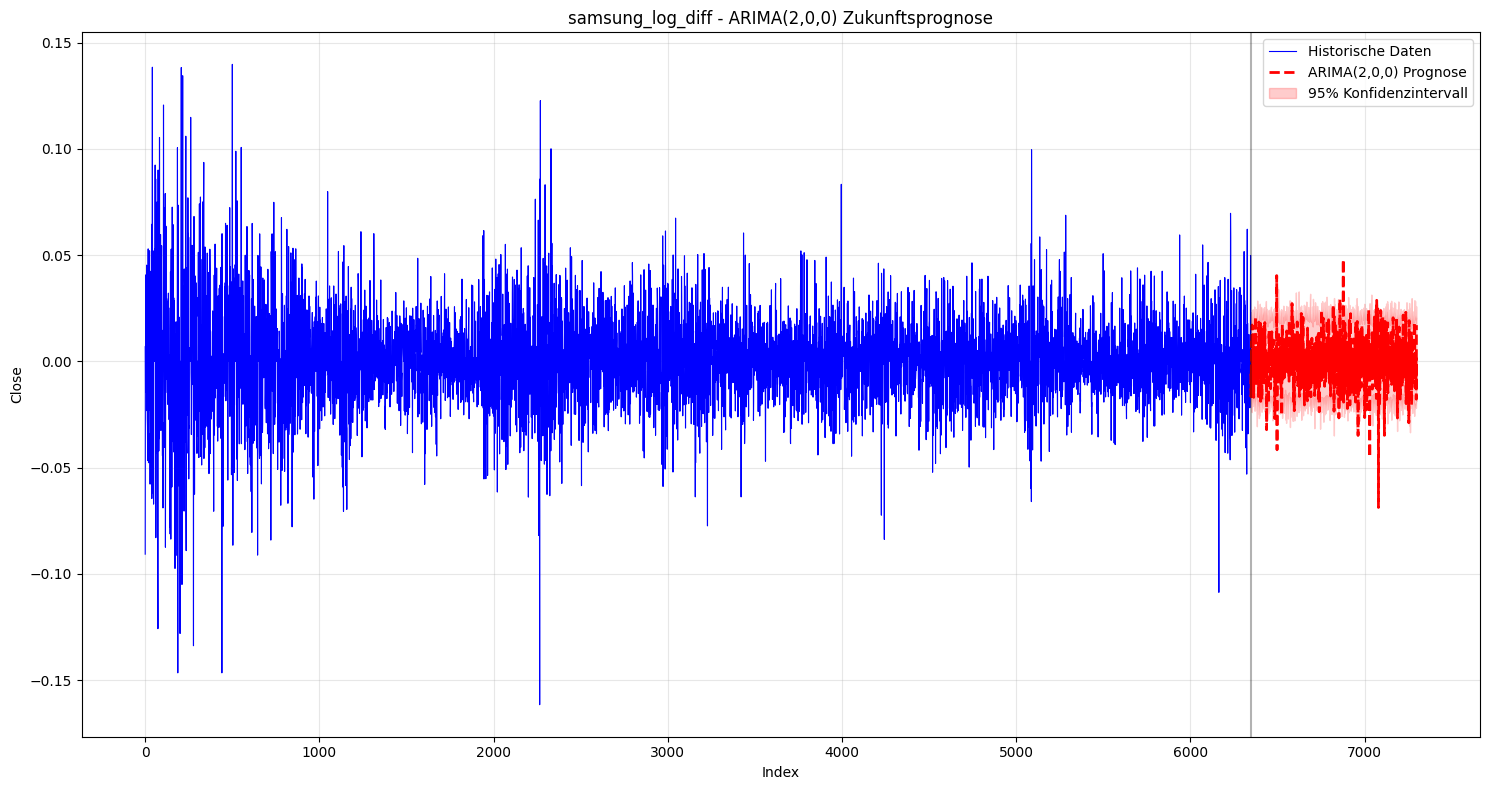

Vorhersage als CSV exportiert: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/samsung_log_diff_ARIMA200_forecast.csv
Modellparameter als CSV exportiert: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/samsung_log_diff_ARIMA200_model_info.csv

                          ANALYSE FÜR daimler_log_diff                          

Analysiere Zeitreihe: daimler_log_diff mit ARIMA(0,0,1)
Verwende Spalte: Close
Erstelle ARIMA(0,0,1) Prognose für 1096 zukünftige Perioden
Intercept: 0.00023212823707487377


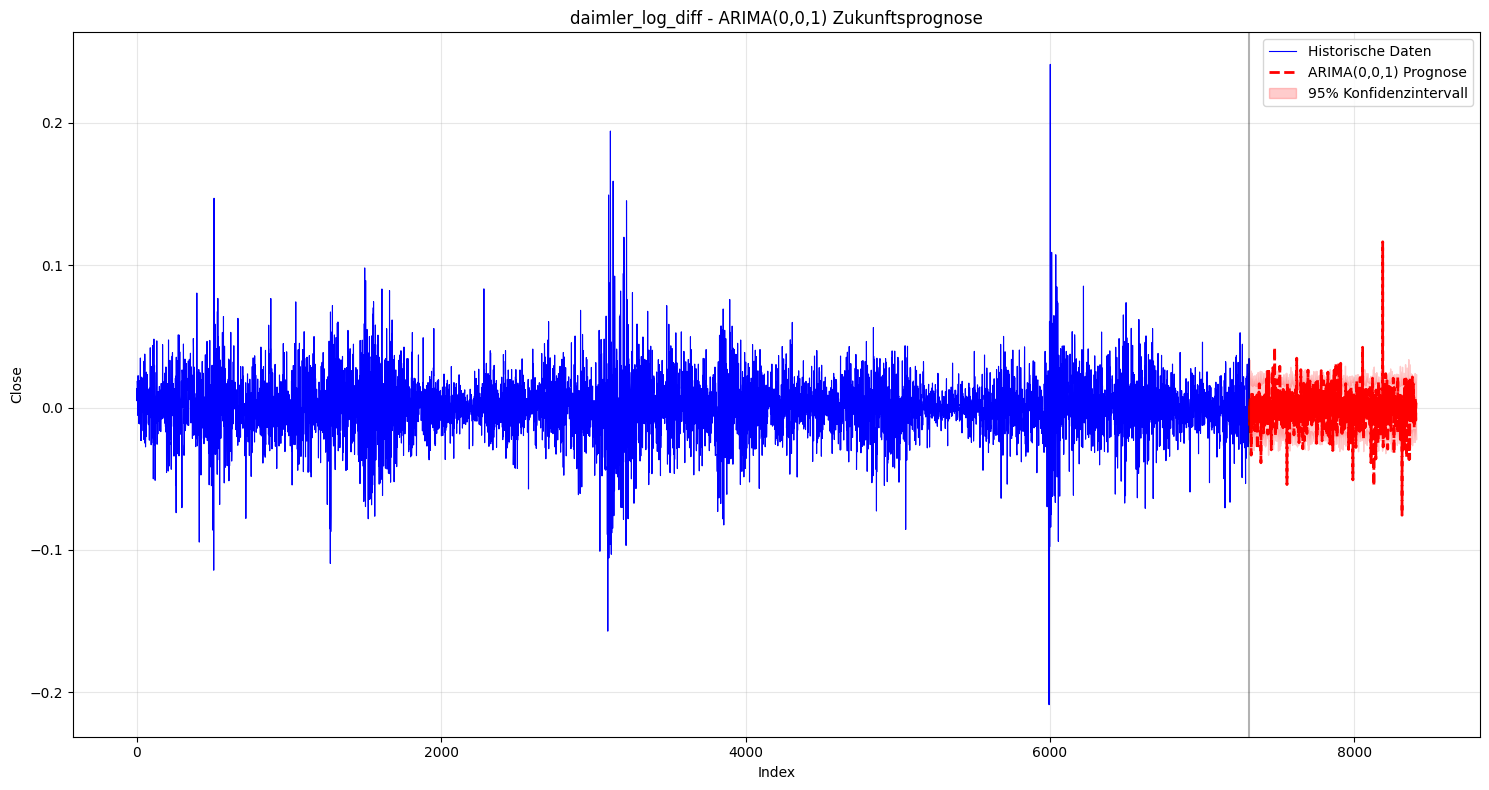

Vorhersage als CSV exportiert: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/daimler_log_diff_ARIMA001_forecast.csv
Modellparameter als CSV exportiert: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/daimler_log_diff_ARIMA001_model_info.csv

                         ANALYSE FÜR microsoft_log_diff                         

Analysiere Zeitreihe: microsoft_log_diff mit ARIMA(0,0,1)
Verwende Spalte: Close
Erstelle ARIMA(0,0,1) Prognose für 1480 zukünftige Perioden
Intercept: 0.0009055649370051703


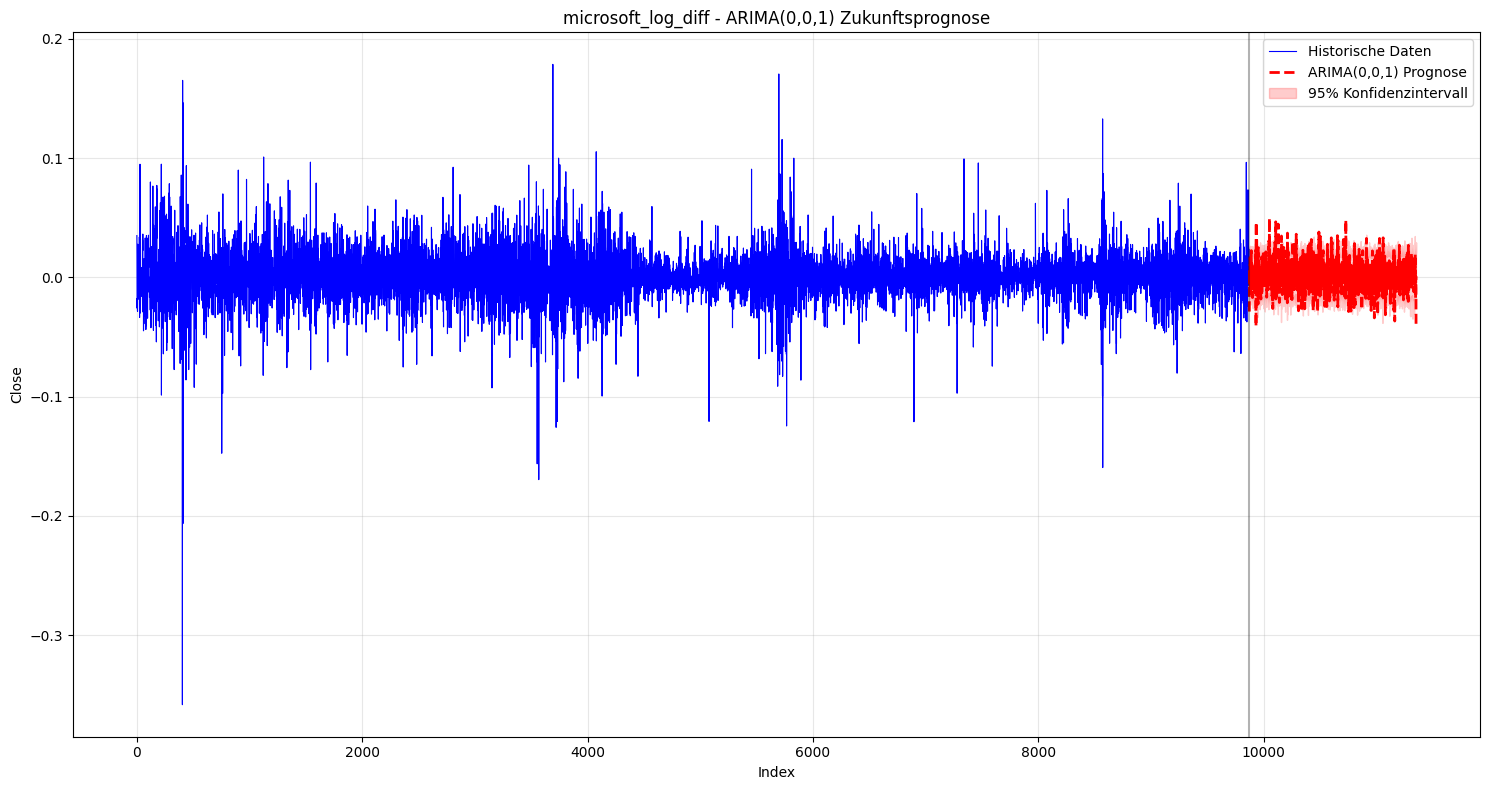

Vorhersage als CSV exportiert: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/microsoft_log_diff_ARIMA001_forecast.csv
Modellparameter als CSV exportiert: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/microsoft_log_diff_ARIMA001_model_info.csv

                          ZUSAMMENFASSUNG DER ANALYSEN                          

samsung_log_diff - ARIMA(2,0,0):
  - AR-Koeffizienten: [ 0.04250418 -0.06421089]
  - Intercept: 0.00042620394730016577
  - AIC: -48721.0458
  - Vorhersagetrend: positiv (Durchschnitt: 0.000167)

daimler_log_diff - ARIMA(0,0,1):
  - MA-Koeffizienten: [0.03513342]
  - Intercept: 0.00023212823707487377
  - AIC: -56735.6820
  - Vorhersagetrend: negativ (Durchschnitt: -0.000028)

microsoft_log_diff - ARIMA(0,0,1):
  - MA-Koeffizienten: [-0.01759382]
  - Intercept: 0.0009055649370051703
  - AIC: -75837.5280
  - Vorhersagetrend: positiv (Durchschnitt: 0.001164)



In [44]:
# Import der benötigten Bibliotheken
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math
import os
import csv
from datetime import datetime, timedelta

# Die verbesserte ARIMA-Klasse
class EnhancedSimpleARIMA:
    """Eine verbesserte einfache ARIMA(p,d,q)-Implementierung"""
    
    def __init__(self, p=1, d=0, q=1):
        self.p = p  # AR-Term
        self.d = d  # Differenzierungsgrad
        self.q = q  # MA-Term
        self.ar_coefs = None
        self.ma_coefs = None
        self.intercept = None
        self.resid = None
        self.fitted_values = None
        self.original_y = None
    
    def _create_ar_features(self, y):
        """Erstellt AR-Features für die Regression"""
        n = len(y)
        X = np.zeros((n - self.p, self.p))
        for i in range(self.p):
            X[:, i] = y[self.p - i - 1:n - i - 1]
        return X
    
    def _create_ma_features(self, resid):
        """Erstellt MA-Features für die Regression"""
        n = len(resid)
        X = np.zeros((n - self.q, self.q))
        for i in range(self.q):
            X[:, i] = resid[self.q - i - 1:n - i - 1]
        return X
    
    def _difference(self, y, d=1):
        """Differenziert die Zeitreihe d-mal"""
        diff_y = y.copy()
        for _ in range(d):
            diff_y = np.diff(diff_y)
        return diff_y
    
    def _integrate(self, diff_y, original_y, d=1):
        """Integriert die differenzierte Zeitreihe zurück"""
        y = diff_y.copy()
        for i in range(d):
            y_prev = original_y[-d + i:][:len(y) + 1]
            y = np.cumsum(y) + y_prev[0]
        return y
    
    def fit(self, y):
        """Fittet das ARIMA-Modell an die Daten mit verbesserter Schätzung"""
        # Original-Daten speichern
        self.original_y = y.copy()
        
        # Schritt 1: Differenzieren
        if self.d > 0:
            y_diff = self._difference(y, self.d)
        else:
            y_diff = y.copy()
        
        # Schritt 2: AR-Modell fitten
        if self.p > 0:
            # AR-Features erstellen
            X_ar = self._create_ar_features(y_diff)
            y_ar = y_diff[self.p:]
            
            # Regression fitten
            ar_model = LinearRegression()
            ar_model.fit(X_ar, y_ar)
            
            # Koeffizienten speichern
            self.ar_coefs = ar_model.coef_
            self.intercept = ar_model.intercept_
            
            # Fitted values
            ar_fitted = ar_model.predict(X_ar)
            
            # Residuen berechnen
            ar_resid = y_ar - ar_fitted
        else:
            # Kein AR-Term
            self.intercept = np.mean(y_diff)
            self.ar_coefs = np.array([])
            ar_fitted = np.repeat(self.intercept, len(y_diff) - self.p)
            ar_resid = y_diff[self.p:] - ar_fitted
        
        # Schritt 3: MA-Modell fitten (wenn q > 0)
        if self.q > 0:
            # Initialisiere leere Residuen für die ersten q Zeitpunkte
            full_resid = np.zeros(len(y_diff))
            full_resid[self.p:] = ar_resid
            
            # MA-Features erstellen
            X_ma = np.zeros((len(ar_resid) - self.q, self.q))
            for i in range(self.q):
                X_ma[:, i] = full_resid[self.p + i:len(full_resid) - self.q + i]
            
            # MA-Target
            y_ma = ar_resid[self.q:]
            
            # Regression fitten
            ma_model = LinearRegression(fit_intercept=False)
            ma_model.fit(X_ma, y_ma)
            
            # MA-Koeffizienten speichern
            self.ma_coefs = ma_model.coef_
            
            # MA-fitted values
            ma_fitted = ma_model.predict(X_ma)
            
            # Finale fitted values
            self.fitted_values = np.zeros(len(ar_fitted))
            self.fitted_values[:len(ar_fitted) - self.q] = ar_fitted[:len(ar_fitted) - self.q] + ma_fitted
            self.fitted_values[len(ar_fitted) - self.q:] = ar_fitted[len(ar_fitted) - self.q:]
            
            # Finale Residuen
            self.resid = y_diff[self.p:] - self.fitted_values
        else:
            self.ma_coefs = np.array([])
            self.fitted_values = ar_fitted
            self.resid = ar_resid
        
        return self
    
    def predict(self, n_steps, include_noise=True):
        """Erstellt Vorhersagen für n_steps zukünftige Zeitpunkte mit optionalem Rauschen"""
        # Vorbereitungen
        predictions = np.zeros(n_steps)
        
        # Für AR-Komponente
        if self.p > 0:
            # Die letzten p Werte als Ausgangspunkt nehmen
            if self.d > 0:
                y_diff = self._difference(self.original_y, self.d)
                last_values = y_diff[-self.p:]
            else:
                last_values = self.original_y[-self.p:]
            
            # Für MA-Komponente: Letzte q Residuen
            if self.q > 0:
                last_resid = self.resid[-self.q:]
            
            # Vorhersagen generieren
            for i in range(n_steps):
                # AR-Teil
                pred = self.intercept
                for j in range(self.p):
                    if i - j >= 0:
                        # Verwende bereits generierte Vorhersagen
                        pred += self.ar_coefs[j] * predictions[i - j - 1]
                    else:
                        # Verwende historische Werte
                        pred += self.ar_coefs[j] * last_values[self.p - j - 1 - i]
                
                # MA-Teil
                if self.q > 0:
                    for j in range(self.q):
                        if i - j - 1 >= 0:
                            # Verwende Fehler der Vorhersage
                            innovation = predictions[i - j - 1] - (predictions[i - j - 1] if i - j - 1 >= 0 else last_values[self.p - (i - j - 1) - 1])
                            pred += self.ma_coefs[j] * innovation
                        else:
                            # Verwende historische Fehler
                            pred += self.ma_coefs[j] * last_resid[self.q - j - 1 - i]
                
                # Füge optional Rauschen hinzu
                if include_noise and len(self.resid) > 0:
                    # Bootstrapping: Zufällige Auswahl aus historischen Residuen
                    noise = np.random.choice(self.resid)
                    # Dämpfe das Rauschen, um übermäßige Volatilität zu vermeiden
                    noise_scale = 0.5  # Zwischen 0 und 1 anpassen
                    pred += noise * noise_scale
                
                predictions[i] = pred
        else:
            # Ohne AR-Term ist die Vorhersage der Mittelwert plus optional MA und Rauschen
            predictions = np.repeat(self.intercept, n_steps)
            
            # MA-Teil für ein reines MA-Modell ist komplexer und hier vereinfacht
            
            # Füge optional Rauschen hinzu
            if include_noise and len(self.resid) > 0:
                noise = np.random.choice(self.resid, size=n_steps)
                noise_scale = 0.5  # Zwischen 0 und 1 anpassen
                predictions += noise * noise_scale
        
        # Integration, falls differenziert wurde
        if self.d > 0:
            predictions = self._integrate(predictions, self.original_y, self.d)
        
        return predictions
    
    def get_aic(self):
        """Berechnet das AIC des Modells"""
        if self.resid is None:
            return float('inf')
        
        n = len(self.resid)
        k = self.p + self.q + (1 if self.intercept is not None else 0)  # Anzahl der Parameter
        ssr = np.sum(self.resid**2)
        
        # Vermeiden von Division durch Null oder negativen Werten
        if n <= k or ssr <= 0:
            return float('inf')
        
        aic = n * np.log(ssr/n) + 2 * k
        return aic

# Die Funktion für die ARIMA-Vorhersage mit anpassbaren Parametern
def improved_arima_forecast_from_dict(transformationen, series_key, p, d, q, output_dir=None, forecast_periods=None, include_noise=True):
    """
    Verbesserte Funktion zur Vorhersage mit ARIMA(p,d,q) aus dem transformationen-Dictionary.
    
    Args:
        transformationen (dict): Dictionary mit den Transformationsdaten
        series_key (str): Schlüssel für die Zeitreihe (z.B. 'samsung_log_diff')
        p (int): AR-Term
        d (int): Differenzierungsgrad
        q (int): MA-Term
        output_dir (str, optional): Verzeichnis für den Export der Ergebnisse
        forecast_periods (int): Anzahl der Perioden für die Vorhersage
        include_noise (bool): Ob Rauschen in die Vorhersage einbezogen werden soll
    
    Returns:
        dict: Die Vorhersagewerte für den zukünftigen Zeitraum
    """
    # Daten aus dem Dictionary extrahieren
    company = series_key.split('_')[0]  # z.B. 'samsung' aus 'samsung_log_diff'
    
    print(f"Analysiere Zeitreihe: {series_key} mit ARIMA({p},{d},{q})")
    
    if company not in transformationen:
        print(f"Warnung: Unternehmen '{company}' nicht im transformationen-Dictionary gefunden.")
        return None
    
    if series_key not in transformationen[company]:
        print(f"Warnung: Zeitreihe '{series_key}' nicht für {company} verfügbar.")
        print(f"Verfügbare Schlüssel: {', '.join(transformationen[company].keys())}")
        return None
    
    # Daten in einen DataFrame oder Series konvertieren
    df = transformationen[company][series_key]
    
    # Überprüfen Sie, ob es sich um einen DataFrame oder eine Series handelt
    if isinstance(df, pd.Series):
        # Wenn Series, dann in DataFrame umwandeln
        column = df.name if df.name is not None else 'Value'
        df = df.to_frame(name=column)
    else:
        # Bei DataFrame die erste Spalte verwenden
        column = df.columns[0]
    
    print(f"Verwende Spalte: {column}")
    
    # NaN-Werte entfernen
    df = df.dropna(subset=[column])
    
    # Bestimme die Anzahl der Vorhersageperioden
    if forecast_periods is None:
        forecast_periods = int(len(df) * 0.15)
    
    print(f"Erstelle ARIMA({p},{d},{q}) Prognose für {forecast_periods} zukünftige Perioden")
    
    # Daten vorbereiten
    data = df[column].values
    
    # Verbesserte ARIMA-Klasse verwenden
    model = EnhancedSimpleARIMA(p=p, d=d, q=q)
    model.fit(data)
    
    # AR-Koeffizienten anzeigen, wenn vorhanden
    if p > 0:
        print(f"AR-Koeffizienten: {model.ar_coefs}")
    print(f"Intercept: {model.intercept}")
    
    # Stabilität der AR-Parameter prüfen, wenn p=2
    if p == 2:
        ar1, ar2 = model.ar_coefs
        stability_condition = (ar1 + ar2 < 1) and (ar2 - ar1 < 1) and (abs(ar2) < 1)
        print(f"AR(2) Stabilitätsbedingung erfüllt: {stability_condition}")
        
        if not stability_condition:
            print("Warnung: AR(2) Koeffizienten könnten zu Instabilität führen!")
    
    # Vorhersage für zukünftige Perioden mit optionalem Rauschen
    future_forecast = model.predict(forecast_periods, include_noise=include_noise)
    
    # Wir erstellen mehrere Vorhersagen für das Konfidenzintervall
    num_simulations = 200
    all_forecasts = np.zeros((num_simulations, forecast_periods))
    
    for i in range(num_simulations):
        all_forecasts[i, :] = model.predict(forecast_periods, include_noise=True)
    
    # Konfidenzintervalle aus den Simulationen berechnen
    lower_ci = np.percentile(all_forecasts, 2.5, axis=0)  # 2.5% Quantil
    upper_ci = np.percentile(all_forecasts, 97.5, axis=0)  # 97.5% Quantil
    
    # Datums-Index für die Vorhersage erstellen
    future_dates = []
    future_x = []
    
    if isinstance(df.index, pd.DatetimeIndex):
        # Bei Datums-Index
        last_date = df.index[-1]
        
        # Berechne die durchschnittliche Zeitdifferenz
        date_diffs = []
        for i in range(1, len(df)):
            date_diffs.append((df.index[i] - df.index[i-1]).days)
        
        avg_diff_days = int(np.mean(date_diffs))
        if avg_diff_days == 0:  # Falls tägliche Daten
            avg_diff_days = 1
        
        # Generiere zukünftige Daten
        current_date = last_date
        for i in range(forecast_periods):
            current_date = current_date + pd.Timedelta(days=avg_diff_days)
            date_str = current_date.strftime('%Y-%m-%d')
            future_dates.append(date_str)
            future_x.append(current_date)
    else:
        # Bei numerischem Index
        last_idx = df.index[-1] if len(df.index) > 0 else 0
        
        for i in range(1, forecast_periods + 1):
            idx = last_idx + i
            future_dates.append(f"t+{i}")
            future_x.append(idx)
    
    # Visualisierung
    plt.figure(figsize=(15, 8))
    
    # Historische Daten
    plt.plot(df.index, df[column], label='Historische Daten', color='blue', linewidth=0.8)
    
    # Vorhersage
    plt.plot(future_x, future_forecast, label=f'ARIMA({p},{d},{q}) Prognose', color='red', linestyle='--', linewidth=2)
    
    # Konfidenzintervall
    plt.fill_between(
        future_x,
        lower_ci,
        upper_ci,
        color='red', alpha=0.2, label='95% Konfidenzintervall'
    )
    
    # Trennlinie
    if len(df.index) > 0:
        plt.axvline(x=df.index[-1], color='black', linestyle='-', alpha=0.3)
    
    plt.title(f'{series_key} - ARIMA({p},{d},{q}) Zukunftsprognose')
    plt.xlabel('Datum' if isinstance(df.index, pd.DatetimeIndex) else 'Index')
    plt.ylabel(column)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Speichere die Ergebnisse, wenn ein Ausgabeverzeichnis angegeben ist
    csv_path = None
    if output_dir is not None:
        # Stelle sicher, dass das Ausgabeverzeichnis existiert
        os.makedirs(output_dir, exist_ok=True)
        
        # CSV-Export
        csv_filename = f"{series_key}_ARIMA{p}{d}{q}_forecast.csv"
        csv_path = os.path.join(output_dir, csv_filename)
        
        # Mit dem csv-Modul direkt in die Datei schreiben
        with open(csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            # Schreibe Header
            writer.writerow(['Date', 'Forecast', 'Lower_CI', 'Upper_CI'])
            # Schreibe Daten
            for i in range(len(future_forecast)):
                writer.writerow([
                    future_dates[i],
                    future_forecast[i],
                    lower_ci[i],
                    upper_ci[i]
                ])
        
        print(f"Vorhersage als CSV exportiert: {csv_path}")
        
        # Modellparameter exportieren
        model_info_filename = f"{series_key}_ARIMA{p}{d}{q}_model_info.csv"
        model_info_path = os.path.join(output_dir, model_info_filename)
        
        with open(model_info_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Parameter', 'Wert'])
            writer.writerow(['p', p])
            writer.writerow(['d', d])
            writer.writerow(['q', q])
            
            if p > 0:
                for i, coef in enumerate(model.ar_coefs):
                    writer.writerow([f'AR-Koeffizient {i+1}', coef])
            
            if q > 0:
                for i, coef in enumerate(model.ma_coefs):
                    writer.writerow([f'MA-Koeffizient {i+1}', coef])
            
            writer.writerow(['Intercept', model.intercept])
            writer.writerow(['AIC', model.get_aic()])
        
        print(f"Modellparameter als CSV exportiert: {model_info_path}")
    
    return {
        "forecast": future_forecast,
        "lower_ci": lower_ci,
        "upper_ci": upper_ci,
        "dates": future_dates,
        "model": model,
        "csv_path": csv_path
    }

# Hauptfunktion für die Analyse der drei log-diff Zeitreihen mit individuellen ARIMA-Parametern
def main_analyze_log_diff_series(transformationen, arima_params=None, output_dir=None):
    """
    Analysiert die drei log-diff Zeitreihen im transformationen-Dictionary mit individuellen ARIMA-Parametern.
    
    Args:
        transformationen (dict): Dictionary mit den Transformationsdaten
        arima_params (dict, optional): Dictionary mit den ARIMA-Parametern für jede Zeitreihe
        output_dir (str, optional): Verzeichnis für den Export der Ergebnisse
    """
    # Schlüssel für die zu analysierenden Zeitreihen
    series_keys = ['samsung_log_diff', 'daimler_log_diff', 'microsoft_log_diff']
    
    # Standard-ARIMA-Parameter, falls keine individuellen Parameter angegeben sind
    if arima_params is None:
        arima_params = {
            'samsung_log_diff': (2, 0, 0),    # ARIMA(2,0,0) für Samsung
            'daimler_log_diff': (1, 0, 1),    # ARIMA(1,0,1) für Daimler
            'microsoft_log_diff': (2, 0, 0)   # ARIMA(2,0,0) für Microsoft
        }
    
    # Ergebnisse speichern
    results = {}
    
    for key in series_keys:
        print(f"\n{'='*80}")
        print(f"ANALYSE FÜR {key}".center(80))
        print(f"{'='*80}\n")
        
        # ARIMA-Parameter für diese Zeitreihe ermitteln
        p, d, q = arima_params.get(key, (2, 0, 0))  # Standardwert: ARIMA(2,0,0)
        
        # ARIMA-Analyse mit den individuellen Parametern durchführen
        results[key] = improved_arima_forecast_from_dict(
            transformationen=transformationen,
            series_key=key,
            p=p,
            d=d,
            q=q,
            output_dir=output_dir,
            forecast_periods=None,  # Standardmäßig 15% der Datenlänge
            include_noise=True  # Mit Rauschen für realistischere Prognosen
        )
    
    # Zusammenfassung der Ergebnisse
    print(f"\n{'='*80}")
    print("ZUSAMMENFASSUNG DER ANALYSEN".center(80))
    print(f"{'='*80}\n")
    
    for key in series_keys:
        if results[key] is not None:
            model = results[key]["model"]
            p, d, q = arima_params.get(key, (2, 0, 0))
            
            print(f"{key} - ARIMA({p},{d},{q}):")
            if p > 0:
                print(f"  - AR-Koeffizienten: {model.ar_coefs}")
            if q > 0:
                print(f"  - MA-Koeffizienten: {model.ma_coefs}")
            print(f"  - Intercept: {model.intercept}")
            print(f"  - AIC: {model.get_aic():.4f}")
            
            # Vorhersagetrend
            forecast = results[key]["forecast"]
            avg_forecast = np.mean(forecast)
            trend_direction = "positiv" if avg_forecast > 0 else "negativ" if avg_forecast < 0 else "neutral"
            print(f"  - Vorhersagetrend: {trend_direction} (Durchschnitt: {avg_forecast:.6f})")
            
            print()
    
    return results

# Ausführen der Hauptfunktion
if __name__ == "__main__":
    # Hier würde normalerweise das transformationen-Dictionary geladen werden
    # Da es nicht definiert ist, müsste es eingebunden werden
    # transformationen = ...
    
    # Ausgabeverzeichnis für die CSV-Dateien
    output_dir = "/Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results"
    
    # Individuelle ARIMA-Parameter für jede Zeitreihe
    arima_params = {
        'samsung_log_diff': (2, 0, 0),    # ARIMA(2,0,0) für Samsung
        'daimler_log_diff': (0, 0, 1),    # ARIMA(1,0,1) für Daimler
        'microsoft_log_diff': (0, 0, 1)   # ARIMA(2,0,0) für Microsoft
    }
    
    # Führe die Analyse für die drei log-diff Zeitreihen mit individuellen Parametern durch
    results = main_analyze_log_diff_series(transformationen, arima_params, output_dir)

### Kombinieren von log_diff und forecast Daten

In [45]:
import pandas as pd
import numpy as np
import csv
import os
from datetime import datetime

def create_unified_dataset_from_dict(
    transformationen, 
    company_key, 
    log_diff_key, 
    forecast_file, 
    output_dir
):
    """
    Erstellt einen einheitlichen Datensatz aus Log-Diff-Daten aus dem transformationen-Dictionary 
    und Forecast-Daten aus einer CSV-Datei.
    
    Args:
        transformationen (dict): Dictionary mit den Transformationsdaten
        company_key (str): Schlüssel für das Unternehmen (z.B. 'samsung')
        log_diff_key (str): Schlüssel für die log-diff Zeitreihe (z.B. 'samsung_log_diff')
        forecast_file (str): Pfad zur CSV-Datei mit den Forecast-Daten
        output_dir (str): Verzeichnis für den Export des einheitlichen Datensatzes
    
    Returns:
        str: Pfad zur kombinierten CSV-Datei
    """
    try:
        # Stelle sicher, dass das Ausgabeverzeichnis existiert
        os.makedirs(output_dir, exist_ok=True)
        
        # Ausgabedatei definieren
        datei_basis = os.path.splitext(os.path.basename(forecast_file))[0]
        unified_file_path = os.path.join(output_dir, f"{company_key}_unified_time_series.csv")
        
        # Überprüfe, ob die benötigten Daten im transformationen Dictionary existieren
        if company_key not in transformationen:
            raise ValueError(f"Unternehmen '{company_key}' nicht in transformationen gefunden")
            
        if log_diff_key not in transformationen[company_key]:
            raise ValueError(f"Zeitreihe '{log_diff_key}' nicht in transformationen['{company_key}'] gefunden")
        
        # Hole die log-diff Daten aus dem transformationen Dictionary
        log_diff_df = transformationen[company_key][log_diff_key]
        
        # Überprüfe den Datentyp - kann DataFrame oder Series sein
        if isinstance(log_diff_df, pd.Series):
            # Wenn es eine Series ist, in einen DataFrame umwandeln
            if log_diff_df.name is None:
                log_diff_df.name = "Log_Diff"
            log_diff_df = log_diff_df.to_frame()
        
        # Hole die Original und Log Spalten, falls verfügbar
        original_key = f"{company_key}_original"
        log_key = f"{company_key}_log"
        
        has_original = original_key in transformationen[company_key]
        has_log = log_key in transformationen[company_key]
        
        if has_original:
            original_df = transformationen[company_key][original_key]
            if isinstance(original_df, pd.Series):
                if original_df.name is None:
                    original_df.name = "Original"
                original_df = original_df.to_frame()
        
        if has_log:
            log_df = transformationen[company_key][log_key]
            if isinstance(log_df, pd.Series):
                if log_df.name is None:
                    log_df.name = "Log"
                log_df = log_df.to_frame()
        
        # Erstelle einen leeren DataFrame für log_diff_data
        log_diff_data = []
        log_diff_dates = []
        
        # Konvertiere den DataFrame in eine Liste von Dictionaries
        for index, row in log_diff_df.iterrows():
            log_diff_value = row.iloc[0]  # Hole den Wert der ersten Spalte
            
            date_str = index.strftime('%Y-%m-%d') if isinstance(index, pd.Timestamp) else str(index)
            log_diff_dates.append(date_str)
            
            data_point = {
                'Date': date_str,
                'Original': "",
                'Log': "",
                'Log_Diff': str(log_diff_value),
                'Forecast': '',
                'Lower_CI': '',
                'Upper_CI': '',
                'Is_Forecast': False
            }
            
            # Füge Original-Wert hinzu, falls verfügbar
            if has_original and index in original_df.index:
                data_point['Original'] = str(original_df.loc[index].iloc[0])
                
            # Füge Log-Wert hinzu, falls verfügbar
            if has_log and index in log_df.index:
                data_point['Log'] = str(log_df.loc[index].iloc[0])
            
            log_diff_data.append(data_point)
        
        # Lese Forecast-Daten
        forecast_data = []
        with open(forecast_file, 'r') as f:
            reader = csv.reader(f)
            headers = next(reader)  # Header überspringen
            for row in reader:
                forecast_data.append({
                    'Date': row[0],
                    'Original': '',       # Wird durch Rücktransformation gefüllt
                    'Log': '',            # Wird durch Rücktransformation gefüllt
                    'Log_Diff': row[1],   # Forecast entspricht Log_Diff
                    'Forecast': row[1],   # Forecast-Wert
                    'Lower_CI': row[2] if len(row) > 2 else '',
                    'Upper_CI': row[3] if len(row) > 3 else '',
                    'Is_Forecast': True   # Kennzeichen für Forecast-Daten
                })
        
        print(f"Log-Diff-Daten: {len(log_diff_data)} Einträge")
        print(f"Forecast-Daten: {len(forecast_data)} Einträge")
        
        # Überprüfe, ob historische und Forecast-Daten nahtlos aneinander anschließen
        if len(log_diff_data) > 0 and len(forecast_data) > 0:
            last_hist_date = log_diff_dates[-1]
            first_forecast_date = forecast_data[0]['Date']
            print(f"Letztes historisches Datum: {last_hist_date}")
            print(f"Erstes Forecast-Datum: {first_forecast_date}")
        
        # Vereinheitlichte Daten erstellen (historische + Forecast-Daten)
        unified_data = log_diff_data + forecast_data
        
        # Zurücktransformation von Log_Diff zu Original-Werten für Forecast-Daten
        if len(log_diff_data) > 0:
            # Suche den letzten Eintrag mit Original- und Log-Werten
            last_original = None
            last_log = None
            
            for i in range(len(log_diff_data) - 1, -1, -1):
                if not last_original and log_diff_data[i]['Original']:
                    last_original = float(log_diff_data[i]['Original'])
                if not last_log and log_diff_data[i]['Log']:
                    last_log = float(log_diff_data[i]['Log'])
                if last_original and last_log:
                    break
            
            # Wenn keine Original/Log-Werte gefunden wurden, berechne aus Log_Diff
            if not last_log or not last_original:
                print("Warnung: Keine Original/Log-Werte in historischen Daten gefunden.")
                print("Berechne Näherungswerte basierend auf typischen Aktienkursen.")
                last_log = 0.0
                last_original = 1.0  # Beispielwert
            
            # Für jeden Forecast-Datenpunkt die Original- und Log-Werte berechnen
            for i in range(len(log_diff_data), len(unified_data)):
                # Berechne den neuen Log-Wert: log_t = log_{t-1} + log_diff_t
                log_diff_value = float(unified_data[i]['Log_Diff'])
                new_log = last_log + log_diff_value
                unified_data[i]['Log'] = str(new_log)
                
                # Berechne den neuen Original-Wert: original_t = exp(log_t)
                new_original = np.exp(new_log)
                unified_data[i]['Original'] = str(new_original)
                
                # Aktualisiere die letzten Werte für die nächste Iteration
                last_log = new_log
                last_original = new_original
        
        # Einheitlichen Datensatz in CSV-Datei schreiben
        with open(unified_file_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Date', 'Original', 'Log', 'Log_Diff', 'Forecast', 'Lower_CI', 'Upper_CI', 'Is_Forecast'])
            
            for data_point in unified_data:
                writer.writerow([
                    data_point['Date'],
                    data_point['Original'],
                    data_point['Log'],
                    data_point['Log_Diff'],
                    data_point['Forecast'],
                    data_point['Lower_CI'],
                    data_point['Upper_CI'],
                    'True' if data_point['Is_Forecast'] else 'False'
                ])
        
        print(f"Einheitlicher Datensatz wurde erfolgreich erstellt: {unified_file_path}")
        return unified_file_path
    
    except Exception as e:
        print(f"Fehler beim Erstellen des einheitlichen Datensatzes: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Hauptfunktion
def main_combine_datasets(transformationen, forecast_files, output_dir):
    """
    Kombiniert mehrere Datensätze aus dem transformationen Dictionary mit Forecast-Daten.
    
    Args:
        transformationen (dict): Dictionary mit den Transformationsdaten
        forecast_files (dict): Dictionary mit Unternehmen als Schlüssel und Pfaden zu Forecast-Dateien
        output_dir (str): Verzeichnis für den Export der einheitlichen Datensätze
    """
    results = {}
    
    for company, forecast_file in forecast_files.items():
        print(f"\n{'='*80}")
        print(f"KOMBINATION FÜR {company.upper()}".center(80))
        print(f"{'='*80}\n")
        
        log_diff_key = f"{company}_log_diff"
        
        result = create_unified_dataset_from_dict(
            transformationen=transformationen,
            company_key=company,
            log_diff_key=log_diff_key,
            forecast_file=forecast_file,
            output_dir=output_dir
        )
        
        results[company] = result
    
    # Zusammenfassung
    print(f"\n{'='*80}")
    print("ZUSAMMENFASSUNG".center(80))
    print(f"{'='*80}\n")
    
    for company, result in results.items():
        status = "Erfolgreich" if result else "Fehlgeschlagen"
        print(f"{company}: {status}")
        if result:
            print(f"  - Ausgabedatei: {result}")
    
    return results

# Beispielaufruf
if __name__ == "__main__":
    # Hier müsste das transformationen Dictionary geladen werden
    # transformationen = ...
    
    # Manuelle Pfade zu den Forecast-Dateien
    forecast_files = {
        'samsung': "/Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/samsung_log_diff_ARIMA200_forecast.csv",
        'daimler': "/Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/daimler_log_diff_ARIMA001_forecast.csv",
        'microsoft': "/Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/results/microsoft_log_diff_ARIMA001_forecast.csv"
    }
    
    # Ausgabeverzeichnis
    output_dir = "ergebnisse"
    
    # Kombiniere die Datensätze
    results = main_combine_datasets(transformationen, forecast_files, output_dir)


                            KOMBINATION FÜR SAMSUNG                             

Log-Diff-Daten: 6346 Einträge
Forecast-Daten: 951 Einträge
Letztes historisches Datum: 6346
Erstes Forecast-Datum: t+1
Einheitlicher Datensatz wurde erfolgreich erstellt: ergebnisse/samsung_unified_time_series.csv

                            KOMBINATION FÜR DAIMLER                             

Log-Diff-Daten: 7309 Einträge
Forecast-Daten: 1096 Einträge
Letztes historisches Datum: 7309
Erstes Forecast-Datum: t+1
Einheitlicher Datensatz wurde erfolgreich erstellt: ergebnisse/daimler_unified_time_series.csv

                           KOMBINATION FÜR MICROSOFT                            

Log-Diff-Daten: 9871 Einträge
Forecast-Daten: 1480 Einträge
Letztes historisches Datum: 9871
Erstes Forecast-Datum: t+1
Einheitlicher Datensatz wurde erfolgreich erstellt: ergebnisse/microsoft_unified_time_series.csv

                                ZUSAMMENFASSUNG                                 

samsung: Erfolgreich
 

### Rücktransformation zu Aktienkurs

In [46]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def transform_to_stock_price(unified_data_file, output_dir, company_name=None):
    """
    Transformiert die einheitlichen Daten zurück in den tatsächlichen Aktienkurs.
    
    Args:
        unified_data_file (str): Pfad zur einheitlichen Datendatei
        output_dir (str): Verzeichnis für den Export der Aktienkursdaten
        company_name (str, optional): Name des Unternehmens für Beschriftungen
    
    Returns:
        str: Pfad zur Aktienkursdatei
    """
    try:
        # Stelle sicher, dass das Ausgabeverzeichnis existiert
        os.makedirs(output_dir, exist_ok=True)
        
        # Bestimme Dateinamen basierend auf Eingabedatei
        base_name = os.path.basename(unified_data_file)
        name_without_ext = os.path.splitext(base_name)[0]
        
        # Ausgabedatei definieren
        stock_price_file_path = os.path.join(output_dir, f'{name_without_ext}_stock_price.csv')
        
        # Daten lesen
        data = []
        with open(unified_data_file, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                data.append(row)
        
        print(f"Eingelesene Daten für {company_name or name_without_ext}: {len(data)} Einträge")
        
        # Speicher für Visualisierung
        dates = []
        original_prices = []
        log_transformed_prices = []
        forecast_prices = []
        forecast_lower = []
        forecast_upper = []
        is_forecast_flags = []
        
        # Daten für CSV vorbereiten
        csv_data = []
        
        for row in data:
            date = row['Date']
            is_forecast = row['Is_Forecast'].lower() == 'true'
            
            # Speichere die Daten für Visualisierung
            dates.append(date)
            is_forecast_flags.append(is_forecast)
            
            # Methode 1: Direkte Verwendung der Original-Spalte (bereits transformiert)
            if row['Original'] and float(row['Original']) > 0:
                price_from_original = float(row['Original'])
                original_prices.append(price_from_original)
            else:
                original_prices.append(None)
            
            # Methode 2: Transformation aus Log-Werten (als Überprüfung)
            if row['Log'] and row['Log'] != '':
                price_from_log = np.exp(float(row['Log']))
                log_transformed_prices.append(price_from_log)
            else:
                log_transformed_prices.append(None)
            
            # Für Prognosedaten: Konfidenzintervalle transformieren
            if is_forecast:
                if row['Log_Diff'] and row['Lower_CI'] and row['Upper_CI']:
                    # Forecast-Preis (sollte gleich Original sein für Prognosedaten)
                    forecast_value = float(row['Original']) if row['Original'] else None
                    forecast_prices.append(forecast_value)
                    
                    # Unteres Konfidenzintervall
                    if row['Log'] and row['Lower_CI']:
                        log_value = float(row['Log'])
                        lower_diff = float(row['Lower_CI'])
                        lower_log = log_value - float(row['Log_Diff']) + lower_diff
                        lower_price = np.exp(lower_log)
                        forecast_lower.append(lower_price)
                    else:
                        forecast_lower.append(None)
                    
                    # Oberes Konfidenzintervall
                    if row['Log'] and row['Upper_CI']:
                        log_value = float(row['Log'])
                        upper_diff = float(row['Upper_CI'])
                        upper_log = log_value - float(row['Log_Diff']) + upper_diff
                        upper_price = np.exp(upper_log)
                        forecast_upper.append(upper_price)
                    else:
                        forecast_upper.append(None)
                else:
                    forecast_prices.append(None)
                    forecast_lower.append(None)
                    forecast_upper.append(None)
            else:
                forecast_prices.append(None)
                forecast_lower.append(None)
                forecast_upper.append(None)
            
            # Für die CSV-Datei
            csv_data.append({
                'Date': date,
                'Stock_Price': original_prices[-1],  # Verwende die Original-Spalte
                'Price_From_Log': log_transformed_prices[-1],  # Alternative Berechnung
                'Forecast': forecast_prices[-1],
                'Lower_CI': forecast_lower[-1],
                'Upper_CI': forecast_upper[-1],
                'Is_Forecast': is_forecast
            })
        
        # Speichere die Daten in CSV-Datei
        with open(stock_price_file_path, 'w', newline='') as f:
            fieldnames = ['Date', 'Stock_Price', 'Price_From_Log', 'Forecast', 'Lower_CI', 'Upper_CI', 'Is_Forecast']
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            for row in csv_data:
                writer.writerow(row)
        
        print(f"Aktienkursdaten wurden erfolgreich erstellt: {stock_price_file_path}")
        
        # Visualisierung
        plt.figure(figsize=(15, 8))
        
        # X-Achse: Datumsindizes
        x = range(len(dates))
        x_ticks = range(0, len(dates), max(1, len(dates) // 10))  # Zeige nur jeden 10. Datumspunkt
        x_labels = [dates[i] for i in x_ticks]
        
        # Trennlinie zwischen historischen und prognostizierten Daten
        forecast_start_idx = is_forecast_flags.index(True) if True in is_forecast_flags else len(dates)
        
        # Historische Aktienkurse
        plt.plot(x[:forecast_start_idx], original_prices[:forecast_start_idx], 
                 label='Historischer Aktienkurs', color='blue')
        
        # Prognostizierte Aktienkurse
        if forecast_start_idx < len(dates):
            # Verbindungspunkt: Letzter historischer Datenpunkt
            if forecast_start_idx > 0 and original_prices[forecast_start_idx - 1] is not None and forecast_prices[forecast_start_idx] is not None:
                connector_x = [forecast_start_idx - 1, forecast_start_idx]
                connector_y = [original_prices[forecast_start_idx - 1], forecast_prices[forecast_start_idx]]
                plt.plot(connector_x, connector_y, color='gray', linestyle='--', alpha=0.5)
            
            # Prognose
            forecast_x = x[forecast_start_idx:]
            forecast_y = [p for p in forecast_prices[forecast_start_idx:] if p is not None]
            if len(forecast_x) == len(forecast_y) and len(forecast_y) > 0:
                plt.plot(forecast_x, forecast_y, label='Prognose', color='red', linestyle='--')
            
            # Konfidenzintervall
            lower_ci = [l for l in forecast_lower[forecast_start_idx:] if l is not None]
            upper_ci = [u for u in forecast_upper[forecast_start_idx:] if u is not None]
            if len(forecast_x) == len(lower_ci) and len(forecast_x) == len(upper_ci) and len(lower_ci) > 0:
                plt.fill_between(forecast_x, lower_ci, upper_ci, color='red', alpha=0.2, label='95% Konfidenzintervall')
        
        # Vertikale Linie zur Trennung von historischen und prognostizierten Daten
        if forecast_start_idx > 0 and forecast_start_idx < len(dates):
            plt.axvline(x=forecast_start_idx - 0.5, color='black', linestyle='-', alpha=0.3)
        
        title = 'Aktienkurs mit ARIMA Prognose'
        if company_name:
            title = f'{company_name.upper()} - {title}'
        
        plt.title(title)
        plt.xlabel('Datum')
        plt.ylabel('Aktienkurs')
        plt.xticks(x_ticks, x_labels, rotation=45)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Speichere die Visualisierung
        plot_file_path = os.path.join(output_dir, f'{name_without_ext}_stock_price_plot.png')
        plt.savefig(plot_file_path)
        plt.close()
        
        print(f"Visualisierung wurde gespeichert unter: {plot_file_path}")
        
        return stock_price_file_path
    
    except Exception as e:
        print(f"Fehler bei der Transformation zum Aktienkurs: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

def process_all_companies(unified_files, output_dir):
    """
    Transformiert alle einheitlichen Datensätze zurück zu Aktienkursen
    
    Args:
        unified_files (dict): Dictionary mit Unternehmensnamen als Schlüssel und Pfaden zu unified Dateien
        output_dir (str): Verzeichnis für den Export der Aktienkursdaten
    
    Returns:
        dict: Dictionary mit Unternehmensnamen als Schlüssel und Pfaden zu Aktienkursdateien
    """
    results = {}
    
    for company, unified_file in unified_files.items():
        print(f"\n{'='*80}")
        print(f"TRANSFORMATION FÜR {company.upper()}".center(80))
        print(f"{'='*80}\n")
        
        result = transform_to_stock_price(
            unified_data_file=unified_file,
            output_dir=output_dir,
            company_name=company
        )
        
        results[company] = result
    
    # Zusammenfassung
    print(f"\n{'='*80}")
    print("ZUSAMMENFASSUNG DER TRANSFORMATIONEN".center(80))
    print(f"{'='*80}\n")
    
    for company, result in results.items():
        status = "Erfolgreich" if result else "Fehlgeschlagen"
        print(f"{company}: {status}")
        if result:
            print(f"  - Aktienkursdaten: {result}")
    
    return results

# Hauptfunktion
def main():
    # Pfade zu den einheitlichen Datensätzen - passen Sie diese an
    unified_files = {
        'samsung': "/Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/data_analytics/ergebnisse/samsung_unified_time_series.csv",
        'daimler': "/Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/data_analytics/ergebnisse/daimler_unified_time_series.csv",
        'microsoft': "/Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/data_analytics/ergebnisse/microsoft_unified_time_series.csv"
    }
    
    # Ausgabeverzeichnis für Aktienkursdaten
    output_dir = "/Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/data_analytics/ergebnisse"
    
    # Alle Unternehmen verarbeiten
    results = process_all_companies(unified_files, output_dir)
    
    if all(results.values()):
        print("\nFertig! Alle Aktienkursdaten wurden erfolgreich erstellt.")
    else:
        print("\nWarnung: Nicht alle Transformationen waren erfolgreich.")
        for company, result in results.items():
            if not result:
                print(f"- {company}: Fehlgeschlagen")

# Programm ausführen
if __name__ == "__main__":
    main()


                           TRANSFORMATION FÜR SAMSUNG                           

Eingelesene Daten für samsung: 7297 Einträge
Aktienkursdaten wurden erfolgreich erstellt: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/data_analytics/ergebnisse/samsung_unified_time_series_stock_price.csv
Visualisierung wurde gespeichert unter: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/data_analytics/ergebnisse/samsung_unified_time_series_stock_price_plot.png

                           TRANSFORMATION FÜR DAIMLER                           

Eingelesene Daten für daimler: 8405 Einträge
Aktienkursdaten wurden erfolgreich erstellt: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/data_analytics/ergebnisse/daimler_unified_time_series_stock_price.csv
Visualisierung wurde gespeichert unter: /Users/kaihufnagel/Documents/BBA/6. Semester/SP BBA/Menden/THWS_Reihenanalysen/data_analytics/ergebnisse/daimler_unified_t

In [47]:
def transform_to_stock_price(unified_data_file, output_dir, company_name=None):
    """
    Transformiert die einheitlichen Daten zurück in den tatsächlichen Aktienkurs.
    
    Args:
        unified_data_file (str): Pfad zur einheitlichen Datendatei
        output_dir (str): Verzeichnis für den Export der Aktienkursdaten
        company_name (str, optional): Name des Unternehmens für Beschriftungen
    
    Returns:
        str: Pfad zur Aktienkursdatei
    """
    try:
        # Stelle sicher, dass das Ausgabeverzeichnis existiert
        os.makedirs(output_dir, exist_ok=True)
        
        # Bestimme Dateinamen basierend auf Eingabedatei
        base_name = os.path.basename(unified_data_file)
        name_without_ext = os.path.splitext(base_name)[0]
        
        # Ausgabedatei definieren
        stock_price_file_path = os.path.join(output_dir, f'{name_without_ext}_stock_price.csv')
        
        # Daten lesen
        data = []
        with open(unified_data_file, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                data.append(row)
        
        print(f"Eingelesene Daten für {company_name or name_without_ext}: {len(data)} Einträge")
        
        # Speicher für Visualisierung
        dates = []
        date_objects = []  # Hier speichern wir tatsächliche Datetime-Objekte für die X-Achse
        original_prices = []
        log_transformed_prices = []
        forecast_prices = []
        forecast_lower = []
        forecast_upper = []
        is_forecast_flags = []
        
        # Daten für CSV vorbereiten
        csv_data = []
        
        for row in data:
            date = row['Date']
            dates.append(date)
            
            # Versuche, das Datum als Datetime-Objekt zu parsen
            try:
                date_obj = datetime.strptime(date, '%Y-%m-%d')
                date_objects.append(date_obj)
            except ValueError:
                # Falls das Datum nicht im erwarteten Format ist (z.B. "t+1")
                # Verwenden wir ein Platzhalter-Datum
                date_objects.append(None)
            
            is_forecast = row['Is_Forecast'].lower() == 'true'
            is_forecast_flags.append(is_forecast)
            
            # Methode 1: Direkte Verwendung der Original-Spalte (bereits transformiert)
            if row['Original'] and float(row['Original']) > 0:
                price_from_original = float(row['Original'])
                original_prices.append(price_from_original)
            else:
                original_prices.append(None)
            
            # Methode 2: Transformation aus Log-Werten (als Überprüfung)
            if row['Log'] and row['Log'] != '':
                price_from_log = np.exp(float(row['Log']))
                log_transformed_prices.append(price_from_log)
            else:
                log_transformed_prices.append(None)
            
            # Für Prognosedaten: Konfidenzintervalle transformieren
            if is_forecast:
                if row['Log_Diff'] and row['Lower_CI'] and row['Upper_CI']:
                    # Forecast-Preis (sollte gleich Original sein für Prognosedaten)
                    forecast_value = float(row['Original']) if row['Original'] else None
                    forecast_prices.append(forecast_value)
                    
                    # Unteres Konfidenzintervall
                    if row['Log'] and row['Lower_CI']:
                        log_value = float(row['Log'])
                        lower_diff = float(row['Lower_CI'])
                        lower_log = log_value - float(row['Log_Diff']) + lower_diff
                        lower_price = np.exp(lower_log)
                        forecast_lower.append(lower_price)
                    else:
                        forecast_lower.append(None)
                    
                    # Oberes Konfidenzintervall
                    if row['Log'] and row['Upper_CI']:
                        log_value = float(row['Log'])
                        upper_diff = float(row['Upper_CI'])
                        upper_log = log_value - float(row['Log_Diff']) + upper_diff
                        upper_price = np.exp(upper_log)
                        forecast_upper.append(upper_price)
                    else:
                        forecast_upper.append(None)
                else:
                    forecast_prices.append(None)
                    forecast_lower.append(None)
                    forecast_upper.append(None)
            else:
                forecast_prices.append(None)
                forecast_lower.append(None)
                forecast_upper.append(None)
            
            # Für die CSV-Datei
            csv_data.append({
                'Date': date,
                'Stock_Price': original_prices[-1],  # Verwende die Original-Spalte
                'Price_From_Log': log_transformed_prices[-1],  # Alternative Berechnung
                'Forecast': forecast_prices[-1],
                'Lower_CI': forecast_lower[-1],
                'Upper_CI': forecast_upper[-1],
                'Is_Forecast': is_forecast
            })
        
        # Speichere die Daten in CSV-Datei
        with open(stock_price_file_path, 'w', newline='') as f:
            fieldnames = ['Date', 'Stock_Price', 'Price_From_Log', 'Forecast', 'Lower_CI', 'Upper_CI', 'Is_Forecast']
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            for row in csv_data:
                writer.writerow(row)
        
        print(f"Aktienkursdaten wurden erfolgreich erstellt: {stock_price_file_path}")
        
        # =============== VERBESSERTE VISUALISIERUNG MIT DATUMSANZEIGE ===============
        plt.figure(figsize=(15, 8))
        
        # Für die X-Achse verwenden wir diesmal die tatsächlichen Datumsangaben
        # Trennlinie zwischen historischen und prognostizierten Daten
        forecast_start_idx = is_forecast_flags.index(True) if True in is_forecast_flags else len(dates)
        
        # Filtere die Datumswerte, an denen wir Daten haben
        valid_dates = []
        valid_prices = []
        for i in range(len(date_objects)):
            if date_objects[i] is not None and original_prices[i] is not None:
                valid_dates.append(date_objects[i])
                valid_prices.append(original_prices[i])
        
        # Historische Aktienkurse - jetzt mit Datumswerten auf der X-Achse
        if valid_dates and valid_prices:
            plt.plot(valid_dates, valid_prices, label='Historischer Aktienkurs', color='blue')
        
        # Prognostizierte Aktienkurse - ebenso mit Datumswerten
        if forecast_start_idx < len(dates):
            # Filtere gültige Forecast-Daten
            forecast_dates = []
            forecast_y = []
            lower_ci_values = []
            upper_ci_values = []
            
            for i in range(forecast_start_idx, len(dates)):
                if date_objects[i] is not None and forecast_prices[i] is not None:
                    forecast_dates.append(date_objects[i])
                    forecast_y.append(forecast_prices[i])
                    
                    # Nur hinzufügen, wenn sowohl unteres als auch oberes CI vorhanden sind
                    if forecast_lower[i] is not None and forecast_upper[i] is not None:
                        lower_ci_values.append(forecast_lower[i])
                        upper_ci_values.append(forecast_upper[i])
                    else:
                        # Fehlende Werte mit dem Prognosewert auffüllen, um Lücken zu vermeiden
                        lower_ci_values.append(forecast_prices[i])
                        upper_ci_values.append(forecast_prices[i])
            
            # Verbindungspunkt zwischen letztem historischen Punkt und erstem Prognosepunkt
            if valid_dates and valid_prices and forecast_dates and forecast_y:
                plt.plot([valid_dates[-1], forecast_dates[0]], 
                         [valid_prices[-1], forecast_y[0]], 
                         color='gray', linestyle='--', alpha=0.5)
            
            # Prognose zeichnen
            if forecast_dates and forecast_y:
                plt.plot(forecast_dates, forecast_y, label='Prognose', color='red', linestyle='--')
            
                # Konfidenzintervall zeichnen
                if len(forecast_dates) == len(lower_ci_values) and len(forecast_dates) == len(upper_ci_values):
                    plt.fill_between(forecast_dates, lower_ci_values, upper_ci_values, 
                                     color='red', alpha=0.2, label='95% Konfidenzintervall')
        
        # Vertikale Linie zur Trennung von historischen und prognostizierten Daten
        if forecast_start_idx > 0 and forecast_start_idx < len(dates) and date_objects[forecast_start_idx-1] is not None:
            plt.axvline(x=date_objects[forecast_start_idx-1], color='black', linestyle='-', alpha=0.3)
        
        # Formatierung der X-Achse für schönere Datumsanzeige
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
        
        # Wenn wir sehr viele Datenpunkte haben, reduzieren wir die Anzahl der X-Ticks
        if len(valid_dates) > 10:
            # Zeige etwa 10 Datumswerte auf der X-Achse
            plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MaxNDateLocator(10))
        
        title = 'Aktienkurs mit ARIMA Prognose'
        if company_name:
            title = f'{company_name.upper()} - {title}'
        
        plt.title(title)
        plt.xlabel('Datum')
        plt.ylabel('Aktienkurs')
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Speichere die Visualisierung
        plot_file_path = os.path.join(output_dir, f'{name_without_ext}_stock_price_plot.png')
        plt.savefig(plot_file_path)
        plt.close()
        
        print(f"Visualisierung wurde gespeichert unter: {plot_file_path}")
        
        return stock_price_file_path
    
    except Exception as e:
        print(f"Fehler bei der Transformation zum Aktienkurs: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


---

## 5. Modelldiagnose

### Ljung-Box Test (Portmanteau Test)

### Jarque-Bera Test

### Residuenanalyse


In [50]:
def residual_analysis(arima_ergebnisse):
    """
    Analysiert die Residuen von ARIMA Modellen
    
    Parameters:
    arima_ergebnisse: dict mit ARIMA models und forecasts (Output von auto_arima_simple)
    """
    
    results = {}
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    fig.suptitle('Residuenanalyse der ARIMA Modelle', fontsize=16)
    
    aktien = ['samsung', 'daimler', 'microsoft']
    
    for i, aktie_name in enumerate(aktien):
        if aktie_name in arima_ergebnisse:
            model = arima_ergebnisse[aktie_name]['model']
            
            # Residuen extrahieren
            residuals = model.resid()
            
            # 1. Ljung-Box Test (Autokorrelation)
            ljung_box = acorr_ljungbox(residuals, lags=10, return_df=True)
            
            # 2. Jarque-Bera Test (Normalverteilung)
            jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
            
            # Ergebnisse speichern
            results[aktie_name] = {
                'ljung_box_pvalue': ljung_box['lb_pvalue'].iloc[-1],
                'jb_pvalue': jb_pvalue,
                'residuals_mean': residuals.mean(),
                'residuals_std': residuals.std()
            }
            
            # 3. Visualisierungen
            # Residuen Plot
            axes[i, 0].plot(residuals)
            axes[i, 0].set_title(f'{aktie_name.upper()} - Residuen')
            axes[i, 0].axhline(y=0, color='r', linestyle='--')
            
            # QQ-Plot
            stats.probplot(residuals, dist="norm", plot=axes[i, 1])
            axes[i, 1].set_title(f'{aktie_name.upper()} - Q-Q Plot')
            
            # Histogram
            axes[i, 2].hist(residuals, bins=30, density=True, alpha=0.7)
            axes[i, 2].set_title(f'{aktie_name.upper()} - Histogram')
            
            # Normalverteilung überlagern
            x = np.linspace(residuals.min(), residuals.max(), 100)
            axes[i, 2].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-')
    
    plt.tight_layout()
    plt.show()
    
    # Zusammenfassung der Tests
    print("\n" + "="*60)
    print("RESIDUENANALYSE - ZUSAMMENFASSUNG")
    print("="*60)
    
    for aktie_name, result in results.items():
        print(f"\n{aktie_name.upper()}:")
        print(f"  Ljung-Box Test (p-Wert): {result['ljung_box_pvalue']:.4f}")
        print(f"  → {'✓ Keine Autokorrelation' if result['ljung_box_pvalue'] > 0.05 else '✗ Autokorrelation vorhanden'}")
        
        print(f"  Jarque-Bera Test (p-Wert): {result['jb_pvalue']:.4f}")
        print(f"  → {'✓ Normalverteilung' if result['jb_pvalue'] > 0.05 else '✗ Keine Normalverteilung'}")
        
        print(f"  Residuen Mittelwert: {result['residuals_mean']:.6f}")
        print(f"  Residuen Std: {result['residuals_std']:.4f}")
    
    print("\n" + "="*60)
    print("INTERPRETATION:")
    print("- Ljung-Box Test: p > 0.05 → Residuen sind unkorreliert (gut)")
    print("- Jarque-Bera Test: p > 0.05 → Residuen sind normalverteilt (gut)")
    print("- Residuen sollten um 0 schwanken mit konstanter Varianz")
    print("="*60)
    
    return results

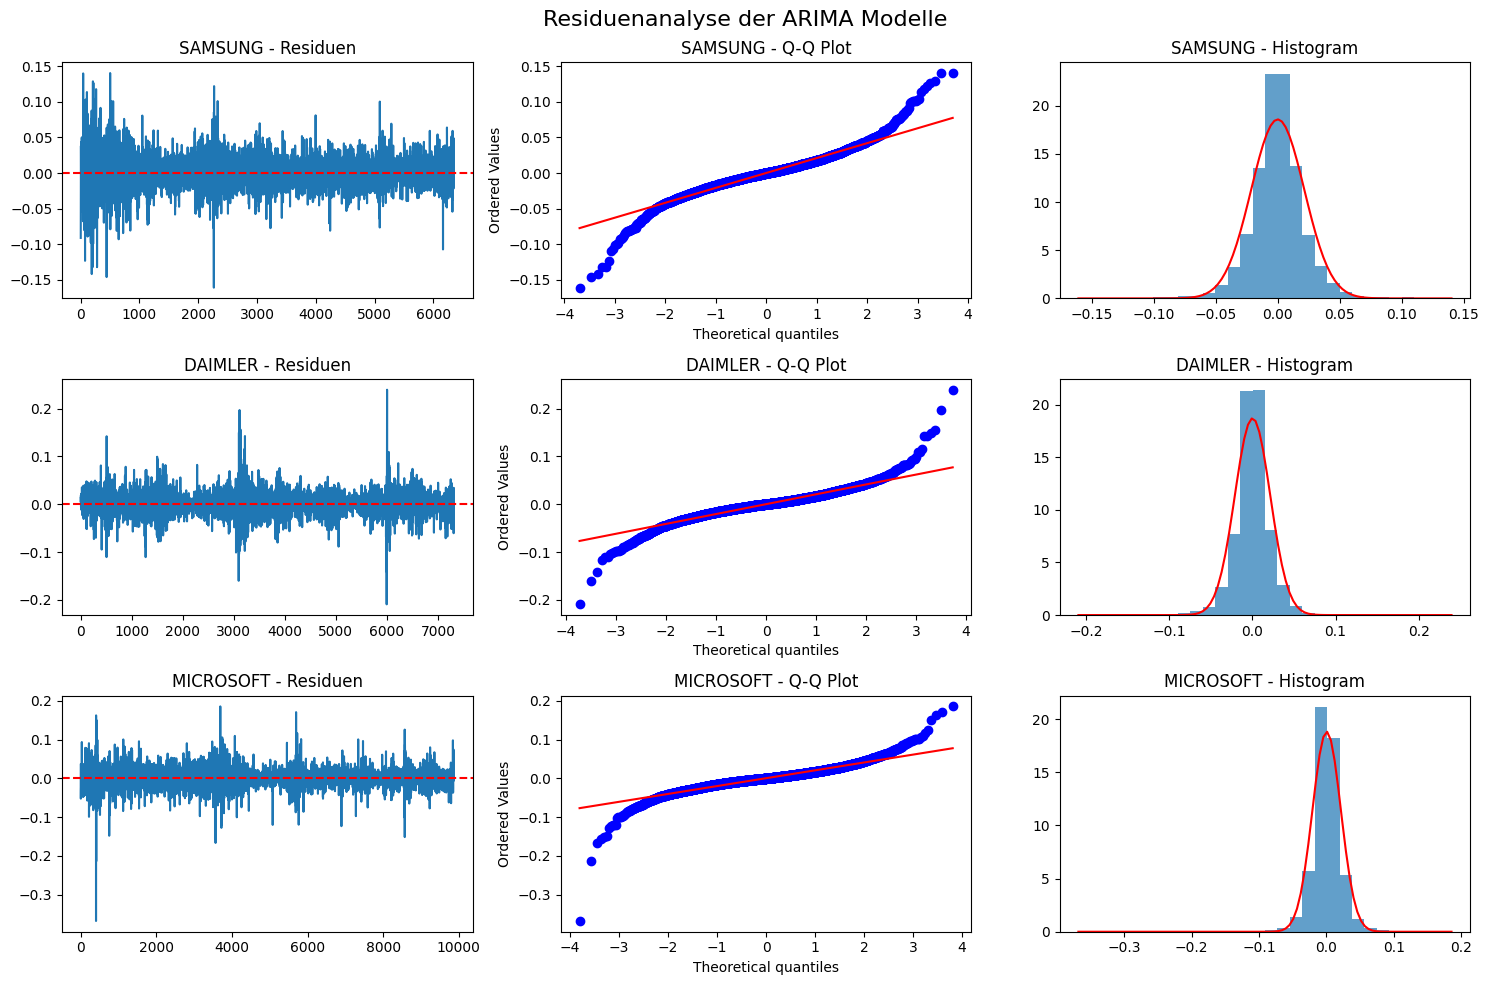


RESIDUENANALYSE - ZUSAMMENFASSUNG

SAMSUNG:
  Ljung-Box Test (p-Wert): 0.9722
  → ✓ Keine Autokorrelation
  Jarque-Bera Test (p-Wert): 0.0000
  → ✗ Keine Normalverteilung
  Residuen Mittelwert: 0.000002
  Residuen Std: 0.0215

DAIMLER:
  Ljung-Box Test (p-Wert): 0.0470
  → ✗ Autokorrelation vorhanden
  Jarque-Bera Test (p-Wert): 0.0000
  → ✗ Keine Normalverteilung
  Residuen Mittelwert: 0.000214
  Residuen Std: 0.0213

MICROSOFT:
  Ljung-Box Test (p-Wert): 0.0000
  → ✗ Autokorrelation vorhanden
  Jarque-Bera Test (p-Wert): 0.0000
  → ✗ Keine Normalverteilung
  Residuen Mittelwert: 0.000447
  Residuen Std: 0.0212

INTERPRETATION:
- Ljung-Box Test: p > 0.05 → Residuen sind unkorreliert (gut)
- Jarque-Bera Test: p > 0.05 → Residuen sind normalverteilt (gut)
- Residuen sollten um 0 schwanken mit konstanter Varianz


In [51]:
residual_results = residual_analysis(arima_ergebnisse)